# Self-Driving Car Engineer Nanodegree

## Advanced Lane Line Finding Project !

This project is about finding lane lines on the road. It is called "Advanced Lane Line finding" because there is already a first version of a lane finder algorithm in https://github.com/Jeremy26/lane-lines

Today, we are using more sophisticated and fitted computer vision techniques to find lane lines on the road and evaluate the position of a car in a lane.

The steps will be the following : 
* Read images
* Process on Camera Calibration with a chessboard picture
* Correct image distortion
* Apply Color & Gradient Threshold in order to find the lanes
* Apply Perspective transform to have a bird's eye view of the road and not a perspective view
* Finally, we need to decide which pixels will be lane lines, we will work on curvatures, radius, and many more

## Read images

In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

## Process on Camera Calibration with a Chessboard Picture

### We first define object points and image points and draw chessboard Corners to check on Calibration

In [107]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images using the Glob API
calibration_images = glob.glob('camera_cal/calibration*.jpg')
test_images = glob.glob('test_images/*.jpg')

In [108]:
def get_points():
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(calibration_images):
        image = mpimg.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(image, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', image)
            if (idx==1):
                plt.imshow(image)
                plt.show()
            cv2.waitKey(500)
    return objpoints, imgpoints

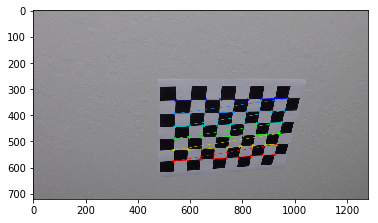

An example of an object point (top-left corner) and its corresponding image point
[ 0.  0.  0.]
[[ 545.32281494  343.05032349]]


In [4]:
## An example of object points and image points
objpoints, imgpoints = get_points()
print("An example of an object point (top-left corner) and its corresponding image point")
print(objpoints[0][0])
print(imgpoints[0][0])
cv2.destroyAllWindows()

#### Then, we are ready to do the camera calibration and undistortion and display one example

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

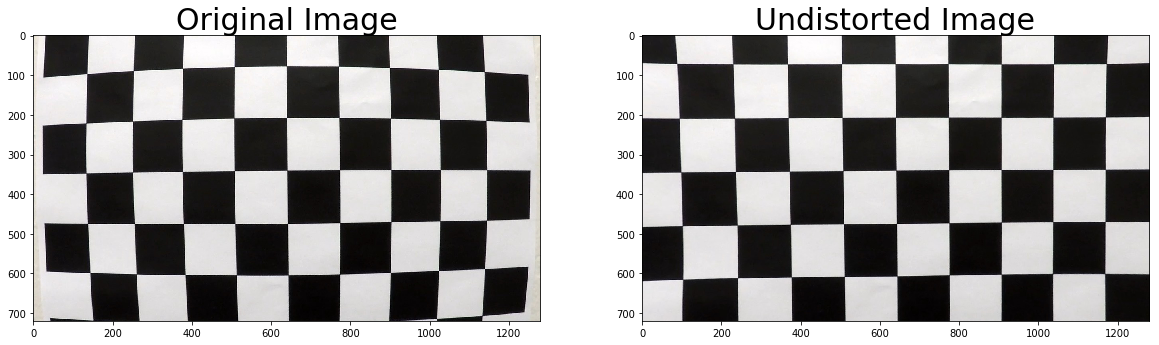

In [6]:
for idx, fname in enumerate (calibration_images):
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # Test on one image
    if (idx==0):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=30)

## Apply Color & Gradient Thresholding in order to find the lanes

### We will take care of gradient first

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return grad_binary

In [8]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

In [9]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

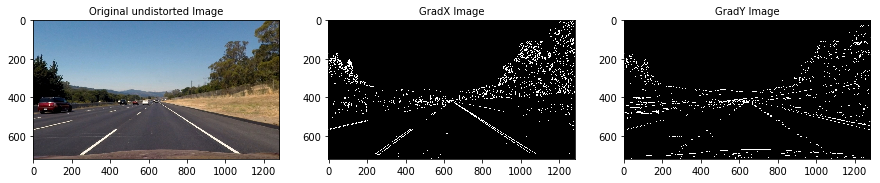

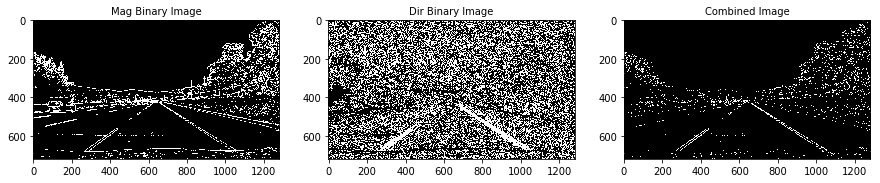

In [10]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        
        # Combine Gradients
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1)&(grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        #Plot the results
        f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(gradx, cmap='gray')
        ax1.set_title('GradX Image', fontsize=10)
        ax2.imshow(grady, cmap='gray')
        ax2.set_title('GradY Image', fontsize =10)
        
        f, (ax3,ax4,ax5) = plt.subplots(1,3, figsize =(15,10))
        ax3.imshow(mag_binary, cmap='gray')
        ax3.set_title('Mag Binary Image', fontsize =10)
        ax4.imshow(dir_binary, cmap='gray')
        ax4.set_title('Dir Binary Image', fontsize =10)
        ax5.imshow(combined, cmap='gray')
        ax5.set_title('Combined Image', fontsize =10)

### Now for Color

In [11]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1    
    return binary_output

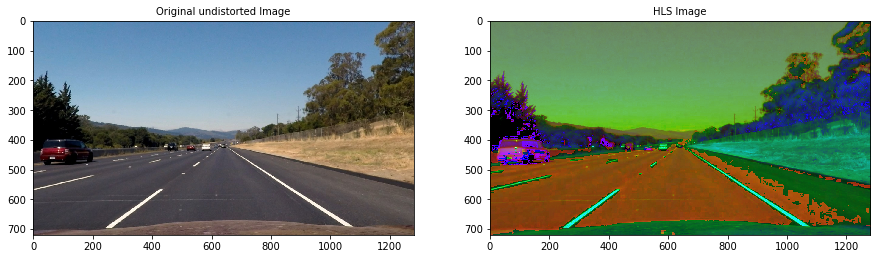

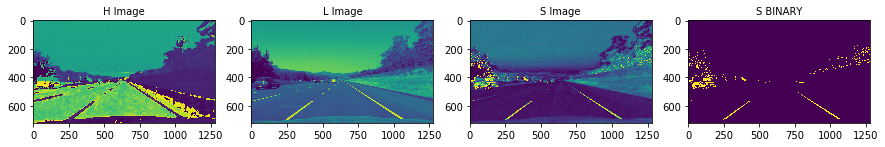

In [12]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        s_binary = hls_select(undistorted, thresh = (170,255))
        
        #Plot the results
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(hls)
        ax1.set_title('HLS Image', fontsize=10)
        f, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4, figsize=(15,10))
        ax2.imshow(H)
        ax2.set_title('H Image', fontsize =10)
        ax3.imshow(L)
        ax3.set_title('L Image', fontsize =10)
        ax4.imshow(S)
        ax4.set_title('S Image', fontsize =10)
        ax5.imshow(s_binary)
        ax5.set_title('S BINARY', fontsize =10)

### Combining the 2

In [13]:
def combined_color_gradient(color, gradient):
    binary = np.dstack(( np.zeros_like(gradient), gradient, color))
    # Combine the two binary thresholds
    combined = np.zeros_like(gradient)
    combined[(color == 1) | (gradient == 1)] = 1
    return combined

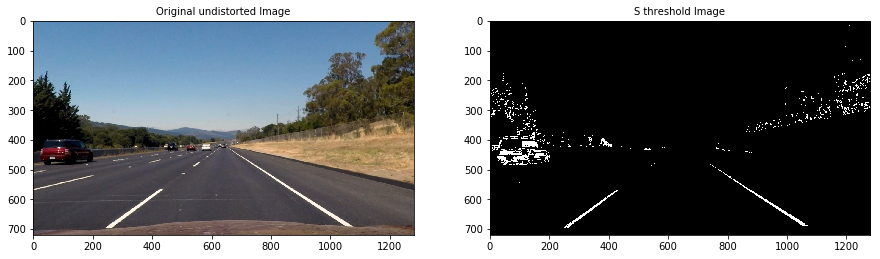

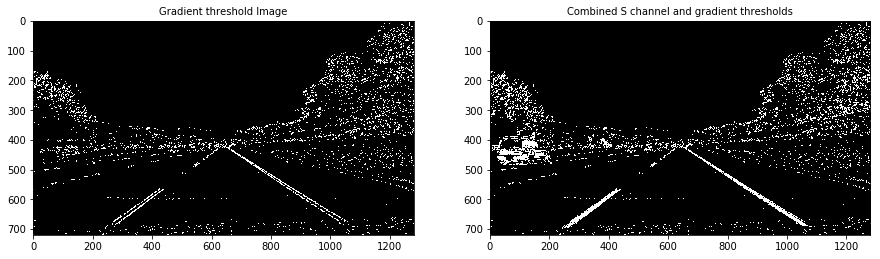

In [14]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        ## COLOR
        s_binary = hls_select(undistorted, thresh = (170,255))
        ## GRADIENT
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        combined_gradient = np.zeros_like(dir_binary)
        combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

        ## COLOR AND GRADIENT
        ccg = combined_color_gradient(s_binary,combined_gradient)
        
        #Plot the results
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(s_binary, cmap='gray')
        ax1.set_title('S threshold Image', fontsize=10)
        f, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,10))
        ax2.imshow(combined_gradient, cmap = 'gray')
        ax2.set_title('Gradient threshold Image', fontsize =10)
        ax3.imshow(ccg, cmap='gray')
        ax3.set_title('Combined S channel and gradient thresholds', fontsize =10)

## Apply perspective Transform

In [15]:
def perspective_transform(img):
    ## The given image is already undistorted
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[575,450],[700,450],[1200,720],[0,720]])
    dst = np.float32([[350, 0], [950, 0],[950, 720],[350,720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

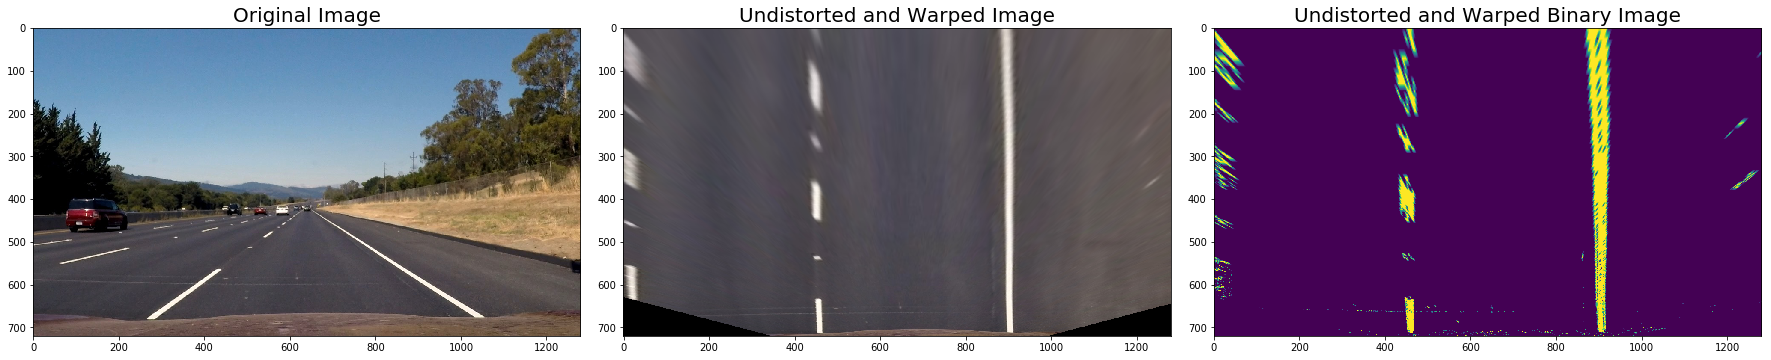

In [16]:
for idx, fname in enumerate (test_images):
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        ## COLOR
        s_binary = hls_select(undistorted, thresh = (170,255))
        ## GRADIENT
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        combined_gradient = np.zeros_like(dir_binary)
        combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        ## COLOR AND GRADIENT
        ccg = combined_color_gradient(s_binary,combined_gradient)    

        ## PERSPECTIVE TRANSFORMED
        birded, M = perspective_transform(undistorted)
        top_down, perspective_M = perspective_transform(ccg)

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(birded)
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        ax3.imshow(top_down)
        ax3.set_title('Undistorted and Warped Binary Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## At this point, we need to identify the right lanes from the left lanes

### Sliding Window using the histogram Peaks

In [109]:
def sliding_window(top_down):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(top_down.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_down.shape[0] - (window+1)*window_height
        win_y_high = top_down.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((top_down, top_down, top_down))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #FOR REPORT ONLY, PLOT THE DATA
#    plt.imshow(out_img)
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
#    plt.xlim(0, 1280)
#    plt.ylim(720, 0)

    return left_fit, right_fit

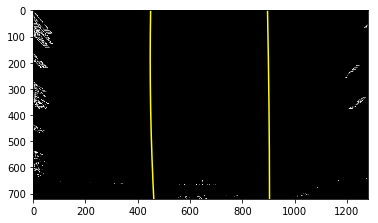

In [18]:
left_fit, right_fit = sliding_window(top_down)

In [110]:
def new_sliding(top_down,left_fit, right_fit):
# Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((top_down, top_down, top_down))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #FOR REPORT ONLY, PLOT THE DATA
  #  plt.imshow(result)
  #  plt.plot(left_fitx, ploty, color='yellow')
  #  plt.plot(right_fitx, ploty, color='yellow')
  #  plt.xlim(0, 1280)
  # plt.ylim(720, 0)

    return result, leftx, rightx,lefty,righty,left_fitx,right_fitx, left_fit, right_fit,ploty 

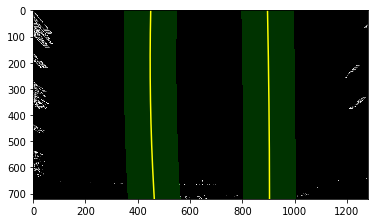

In [34]:
result,leftx,rightx,lefty,righty,left_fitx, right_fitx,left_fit,right_fit,ploty = new_sliding(top_down,left_fit, right_fit)

## Now, we measure the radius of curvature

In [111]:
def curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty):  
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
   # print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
   # print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

8737.42457486 36860.5509424
1631.44720114 m 6918.26444812 m
4274.85582463


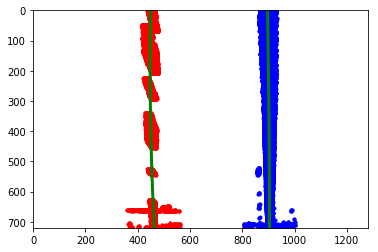

In [74]:
    ##PLOTING FOR REPORT ONLY
#    mark_size = 3
#    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
#    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
#    plt.xlim(0, 1280)
#    plt.ylim(0, 720)
#    plt.plot(left_fitx, ploty, color='green', linewidth=3)
#    plt.plot(right_fitx, ploty, color='green', linewidth=3)
#    plt.gca().invert_yaxis() # to visualize as we do the images

left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
curve = (left_curverad+right_curverad)/2.0
print(left_curverad)
print(right_curverad)
print(curve)

### Determine the position to the center of the lane

In [112]:
def position_to_center(left_fitx, right_fitx,result):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_center = result.shape[1]/2.0
    xm_per_pix = 3.7/700
    distance_to_center = (lane_center - camera_center)*xm_per_pix
    return distance_to_center

In [45]:
distance_to_center = position_to_center(left_fitx,right_fitx,result)
print(distance_to_center)

0.230656624204


## Plot the Images

In [113]:
def draw_on_lane(img, undistorted,top_down, perspective_M, left_fitx, right_fitx, ploty, curve, distance):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(result_img,"Curvature "+str(curve),(400,100), font, 1,(255,255,255),2)
    cv2.putText(result_img,"Distance to Center "+str(distance),(400,150), font, 1,(255,255,255),2)

    return result_img

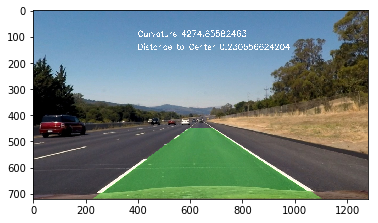

In [101]:
result_img = draw_on_lane(img, undistorted,top_down, np.linalg.inv(perspective_M),left_fitx, right_fitx, ploty,curve,distance_to_center)

plt.imshow(result_img)

## Define Main function

In [ ]:
objpoints, imgpoints = get_points()

In [62]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    ## COLOR THRESHOLD
    s_binary = hls_select(undistorted, thresh = (170,255))
    ## GRADIENT THRESHOLD
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
    mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    ## COMBINED COLOR AND GRADIENT
    ccg = combined_color_gradient(s_binary,combined_gradient)    

    ## PERSPECTIVE TRANSFORMED
    top_down, perspective_M = perspective_transform(ccg)

    ## SLIDING WINDOW SEARCH
    left_fit, right_fit = sliding_window(top_down)
    result,leftx,rightx,lefty,righty,left_fitx, right_fitx,left_fit,right_fit,ploty = new_sliding(top_down,left_fit, right_fit)
    
    ## RADIUS OF CURVATURE
    left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
    curve = (left_curverad + right_curverad)/2.0
    
    ## POSITION TO CENTER
    distance_to_center = position_to_center(left_fitx,right_fitx,result)
    
    ## DRAW ON LANE
    result_img = draw_on_lane(img, undistorted,top_down, np.linalg.inv(perspective_M),left_fitx, right_fitx, ploty,curve,distance_to_center)

    return result_img

## Test on Images

8969.70472702 36860.5509424
1675.22506232 m 6918.26444812 m
0.229841139436


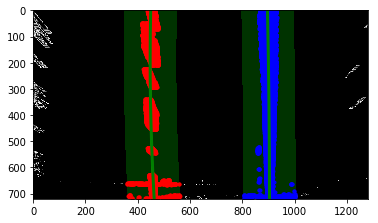

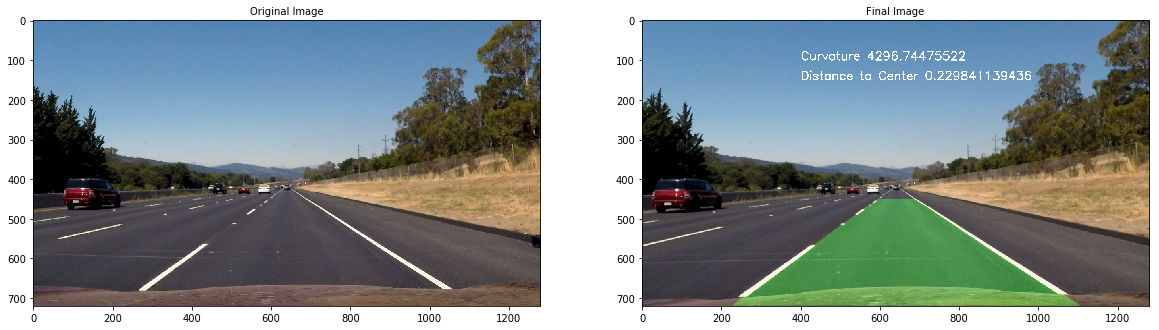

In [102]:
for idx, fname in enumerate (test_images):
    if (idx==1):
        img = mpimg.imread(fname)
        result_img = pipeline(img)
            
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
        ax1.imshow(img)
        ax1.set_title("Original Image", fontsize=10)

        ax2.imshow(result_img)
        ax2.set_title("Final Image", fontsize=10)

## Test on Project Video

365063.831708 6310.1712172
67307.8224671 m 1183.86411403 m
0.345356586754
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



  1%|          | 1/126 [00:00<02:04,  1.01it/s]

365063.831708 6310.1712172
67307.8224671 m 1183.86411403 m
0.345356586754



  2%|▏         | 2/126 [00:01<02:02,  1.01it/s]

36485.1817086 6356.48223323
6732.85830415 m 1192.34537697 m
0.349302316932



  2%|▏         | 3/126 [00:03<02:03,  1.00s/it]

110615.478742 14085.9946222
20361.9666505 m 2634.6513362 m
0.359733289785



  3%|▎         | 4/126 [00:04<02:05,  1.03s/it]

68041.3289299 84290.1485489
12517.5194404 m 15701.9553731 m
0.36968023748



  4%|▍         | 5/126 [00:05<02:03,  1.02s/it]

139994.354835 11973.7595721
25727.7031866 m 2239.33238473 m
0.364181783118



  5%|▍         | 6/126 [00:06<02:02,  1.02s/it]

15021.0094851 73620.2073466
2729.81296248 m 13706.050323 m
0.375738306686


  6%|▌         | 7/126 [00:07<02:00,  1.01s/it]

10438.5564112 18452.4084496
1886.22794097 m 3451.56148361 m
0.364895547532


  6%|▋         | 8/126 [00:08<01:57,  1.01it/s]

8515.67821782 39703.8252007
1533.68544963 m 7398.98855118 m
0.368134502211


  7%|▋         | 9/126 [00:09<01:56,  1.00it/s]

10869.6613282 20908.2744207
1962.71708348 m 3911.63538536 m
0.358915303084


  8%|▊         | 10/126 [00:10<01:55,  1.00it/s]

9797.65094431 7732.54520096
1765.7296924 m 1450.56700368 m
0.350758211066


  9%|▊         | 11/126 [00:11<01:54,  1.00it/s]

6978.88298468 121492.904387
1250.40172585 m 22662.312126 m
0.365752840205


 10%|▉         | 12/126 [00:12<01:54,  1.01s/it]

5187.3463463 3621.48589329
920.064874707 m 679.133855748 m
0.344205561104


 10%|█         | 13/126 [00:13<01:52,  1.00it/s]

6048.31547613 7368.59681532
1079.39454311 m 1381.16569402 m
0.356537892151


 11%|█         | 14/126 [00:14<01:51,  1.00it/s]

7170.06685396 18096.5939407
1285.08991003 m 3353.4377107 m
0.374743155202


 12%|█▏        | 15/126 [00:15<01:50,  1.00it/s]

4515.7994853 4599.24378612
802.611327593 m 836.017841804 m
0.388877226559


 13%|█▎        | 16/126 [00:16<01:49,  1.01it/s]

5242.17768784 2773.20301345
940.552966056 m 493.638471627 m
0.390881748137


 13%|█▎        | 17/126 [00:17<01:48,  1.00it/s]

6237.12681659 3093.32210026
1124.26390561 m 553.432764786 m
0.382427499027


 14%|█▍        | 18/126 [00:18<01:46,  1.01it/s]

13028.1043882 3055.52017913
2381.38530805 m 549.149720775 m
0.36440822517


 15%|█▌        | 19/126 [00:19<01:47,  1.01s/it]

5254.72719628 3669.23542991
944.822718255 m 664.236930648 m
0.368076039582


 16%|█▌        | 20/126 [00:20<01:45,  1.00it/s]

6748.28392835 4622.3517644
1224.06558307 m 847.323089756 m
0.342156896708


 17%|█▋        | 21/126 [00:21<01:45,  1.00s/it]

7901.51728294 31178.2810921
1437.13584384 m 5810.46346294 m
0.32102694222


 17%|█▋        | 22/126 [00:22<01:43,  1.00it/s]

11536.2477407 7950.4834474
2103.31253766 m 1491.55470268 m
0.304566689599


 18%|█▊        | 23/126 [00:23<01:42,  1.01it/s]

14588.2742331 6599.39986744
2661.36469476 m 1238.56027181 m
0.30259030413


 19%|█▉        | 24/126 [00:23<01:40,  1.01it/s]

7135.42938476 8076.87919426
1286.19113133 m 1514.79245318 m
0.325489650628


 20%|█▉        | 25/126 [00:24<01:39,  1.01it/s]

7834.01945145 10855.5521255
1413.10936826 m 2034.3348171 m
0.331082582703


 21%|██        | 26/126 [00:25<01:38,  1.02it/s]

9324.91440723 5520.49975927
1686.64594328 m 1035.87570079 m
0.325984084395


 21%|██▏       | 27/126 [00:26<01:37,  1.02it/s]

4596.94505935 9714.64142509
819.158279197 m 1818.50483158 m
0.344434911026


 22%|██▏       | 28/126 [00:27<01:37,  1.00it/s]

4703.77824412 8504.30110354
838.572878083 m 1592.93735114 m
0.342794906345


 23%|██▎       | 29/126 [00:29<01:41,  1.05s/it]

4744.74332969 21906.2470139
847.95395245 m 4067.5866118 m
0.355743704353


 24%|██▍       | 30/126 [00:30<01:40,  1.05s/it]

5426.10676244 14686.8977424
975.918523613 m 2720.48040586 m
0.356189749714


 25%|██▍       | 31/126 [00:31<01:37,  1.03s/it]

13262.8491252 19752.107303
2420.07533997 m 3660.65174934 m
0.347890144105


 25%|██▌       | 32/126 [00:32<01:35,  1.02s/it]

22880.5786848 4087.855568
4196.79429213 m 745.12948959 m
0.353549351851


 26%|██▌       | 33/126 [00:33<01:34,  1.02s/it]

15275.8989019 6647.29130839
2792.29835404 m 1227.06073423 m
0.341689729066


 27%|██▋       | 34/126 [00:34<01:33,  1.02s/it]

5192.26342148 3795.0530417
934.839654293 m 691.72918547 m
0.3625075289


 28%|██▊       | 35/126 [00:35<01:35,  1.05s/it]

6121.11590173 4935.76463496
1106.19363692 m 907.882110528 m
0.354861911508


 29%|██▊       | 36/126 [00:36<01:38,  1.10s/it]

4894.08687148 4912.49205586
879.097027604 m 901.776294113 m
0.364271081818


 29%|██▉       | 37/126 [00:37<01:41,  1.15s/it]

4753.84165612 3726.91980835
851.733327342 m 679.640971561 m
0.372360676698


 30%|███       | 38/126 [00:38<01:40,  1.14s/it]

4307.1992941 4199.53312597
770.163862945 m 765.146215225 m
0.378003150174


 31%|███       | 39/126 [00:40<01:40,  1.15s/it]

3620.91877935 3573.24183587
641.865778745 m 650.774759265 m
0.380199235981


 32%|███▏      | 40/126 [00:41<01:35,  1.11s/it]

2928.24546018 3049.70931663
511.558440772 m 550.332220505 m
0.395585442334


 33%|███▎      | 41/126 [00:42<01:31,  1.08s/it]

2898.9258241 2615.26303615
506.522336338 m 464.55105115 m
0.406362040463


 33%|███▎      | 42/126 [00:43<01:28,  1.05s/it]

2555.00018659 2647.84619642
442.176602806 m 471.091228122 m
0.409847946001


 34%|███▍      | 43/126 [00:44<01:26,  1.04s/it]

4556.21890422 2525.38742914
805.077255501 m 447.195384551 m
0.407623826909


 35%|███▍      | 44/126 [00:45<01:23,  1.02s/it]

8183.68414801 4551.87543209
1466.73383126 m 832.7372606 m
0.379549090337


 36%|███▌      | 45/126 [00:46<01:21,  1.01s/it]

10623.221899 4367.42644457
1909.28006012 m 798.020561735 m
0.376025347746


 37%|███▋      | 46/126 [00:47<01:21,  1.02s/it]

6486.98773297 4902.74446875
1152.63765944 m 901.783597139 m
0.371249955421


 37%|███▋      | 47/126 [00:48<01:23,  1.05s/it]

7308.80237799 4391.96487596
1301.01919526 m 803.413497799 m
0.376195387774


 38%|███▊      | 48/126 [00:49<01:21,  1.05s/it]

5020.42900406 3439.21493928
884.02115685 m 625.150136882 m
0.38530884119


 39%|███▉      | 49/126 [00:50<01:24,  1.09s/it]

5774.50347955 6038.94468207
1020.00912237 m 1113.16440797 m
0.373217418292


 40%|███▉      | 50/126 [00:51<01:25,  1.12s/it]

5348.19513381 3884.61051606
943.926257083 m 711.387383073 m
0.376223132419


 40%|████      | 51/126 [00:52<01:22,  1.10s/it]

5004.88786233 6877.73483684
881.447044547 m 1266.40857174 m
0.37769882019


 41%|████▏     | 52/126 [00:53<01:23,  1.12s/it]

3327.27883836 3750.84415528
575.143752695 m 684.672955328 m
0.388273023717


 42%|████▏     | 53/126 [00:54<01:20,  1.11s/it]

3845.95089707 3463.24136897
671.438399018 m 623.687614436 m
0.397267361974


 43%|████▎     | 54/126 [00:56<01:18,  1.09s/it]

2287.84953071 2906.4462124
384.211625746 m 521.637700703 m
0.407739980649


 44%|████▎     | 55/126 [00:57<01:16,  1.08s/it]

2403.91511319 2977.23783773
404.758924726 m 534.34033827 m
0.407120121625


 44%|████▍     | 56/126 [00:58<01:14,  1.07s/it]

2753.69074952 2885.97145197
470.574385469 m 517.634843209 m
0.398053292933


 45%|████▌     | 57/126 [00:59<01:13,  1.06s/it]

5484.1946785 3342.86768065
972.314392112 m 605.501880488 m
0.374266840774


 46%|████▌     | 58/126 [01:00<01:11,  1.05s/it]

9401.54619319 4292.12638489
1687.32913915 m 786.389352289 m
0.355655063597


 47%|████▋     | 59/126 [01:01<01:09,  1.03s/it]

3646.14645331 3331.57322305
636.592114255 m 605.552027091 m
0.373554457486


 48%|████▊     | 60/126 [01:02<01:07,  1.02s/it]

5299.90398942 3019.60532227
942.681525283 m 546.619382259 m
0.36668984204


 48%|████▊     | 61/126 [01:03<01:05,  1.01s/it]

4611.69132321 2986.60542323
816.822835061 m 541.051399873 m
0.36714236391


 49%|████▉     | 62/126 [01:04<01:03,  1.00it/s]

3356.62539586 2894.96887256
586.811801277 m 523.816034961 m
0.372146434234


 50%|█████     | 63/126 [01:05<01:03,  1.00s/it]

3576.69214666 2738.66028762
627.851309071 m 490.810229924 m
0.378431974291


 51%|█████     | 64/126 [01:06<01:02,  1.01s/it]

2929.66966361 3106.13123647
509.221425545 m 563.305280783 m
0.372807019016


 52%|█████▏    | 65/126 [01:07<01:02,  1.03s/it]

5080.68005901 2880.75897701
906.632622355 m 519.419043812 m
0.365664135477


 52%|█████▏    | 66/126 [01:08<01:01,  1.02s/it]

3406.95445389 2243.27352589
599.392345939 m 395.609268968 m
0.383978409775


 53%|█████▎    | 67/126 [01:09<01:00,  1.02s/it]

2995.5774718 2496.94498003
522.846597196 m 444.15622399 m
0.381434959207


 54%|█████▍    | 68/126 [01:10<00:58,  1.00s/it]

2759.9000201 2324.94070861
478.809550212 m 410.935242602 m
0.385141666545


 55%|█████▍    | 69/126 [01:11<01:01,  1.07s/it]

2591.50543844 2560.48765077
448.859963591 m 458.357433172 m
0.374610059179


 56%|█████▌    | 70/126 [01:12<00:59,  1.06s/it]

3371.54641867 2926.0044759
592.875624032 m 526.491326307 m
0.366947654812


 56%|█████▋    | 71/126 [01:13<00:58,  1.06s/it]

2883.85397168 3019.60620752
502.303305901 m 546.303158375 m
0.364225641326


 57%|█████▋    | 72/126 [01:14<00:56,  1.04s/it]

4016.54075757 3318.6823336
712.318364722 m 604.572997628 m
0.349633253377


 58%|█████▊    | 73/126 [01:15<00:55,  1.04s/it]

3677.15073651 3404.44979805
650.310781478 m 621.598970352 m
0.346698126846


 59%|█████▊    | 74/126 [01:16<00:53,  1.02s/it]

3479.8812012 3597.96012015
613.679375261 m 655.644584153 m
0.350971657243


 60%|█████▉    | 75/126 [01:17<00:51,  1.02s/it]

5192.12521724 4353.56629753
930.614194006 m 797.810431972 m
0.33745810071


 60%|██████    | 76/126 [01:18<00:50,  1.02s/it]

7135.74009903 3362.21478108
1290.87410192 m 611.254888846 m
0.336117935573


 61%|██████    | 77/126 [01:19<00:50,  1.03s/it]

14139.373256 4245.20214429
2577.17372291 m 777.158367104 m
0.326434184742


 62%|██████▏   | 78/126 [01:20<00:49,  1.03s/it]

13886.7876489 4989.60791313
2531.30206133 m 912.3826825 m
0.329456503012


 63%|██████▎   | 79/126 [01:21<00:48,  1.04s/it]

15324.1262066 7339.26132508
2796.33722515 m 1356.0284335 m
0.315199680468


 63%|██████▎   | 80/126 [01:22<00:47,  1.03s/it]

34494.5483466 7931.40456253
6325.6589893 m 1465.59159706 m
0.31034154188


 64%|██████▍   | 81/126 [01:23<00:46,  1.03s/it]

20410.8977196 5468.7917972
3737.37483737 m 1005.04696056 m
0.314381878976


 65%|██████▌   | 82/126 [01:24<00:45,  1.03s/it]

50097.5309028 5703.28632301
9249.9458272 m 1047.81011297 m
0.303766036756


 66%|██████▌   | 83/126 [01:25<00:44,  1.03s/it]

37392.9142619 4767.27107918
6913.95690469 m 875.971509231 m
0.296643957305


 67%|██████▋   | 84/126 [01:26<00:43,  1.02s/it]

17202.4546489 548508.542422
3187.90953162 m 102456.704038 m
0.271965491463


 67%|██████▋   | 85/126 [01:27<00:41,  1.02s/it]

26462.8689782 23794.6636266
4899.49417621 m 4455.64406369 m
0.267121951661


 68%|██████▊   | 86/126 [01:28<00:40,  1.01s/it]

25890.3140441 9861.69401953
4796.26606278 m 1831.07730881 m
0.281144600703


 69%|██████▉   | 87/126 [01:29<00:39,  1.01s/it]

24673.784575 5156.174442
4580.27115896 m 950.900788039 m
0.288961417966


 70%|██████▉   | 88/126 [01:30<00:38,  1.02s/it]

25279.5137763 4657.60912162
4662.60520854 m 856.570614803 m
0.301356128183


 71%|███████   | 89/126 [01:31<00:38,  1.03s/it]

10004.900604 3779.49363092
1835.7649105 m 688.874498664 m
0.31627897945


 71%|███████▏  | 90/126 [01:32<00:36,  1.02s/it]

83453.2149177 3621.06195042
15456.2735 m 662.530602298 m
0.307553356033


 72%|███████▏  | 91/126 [01:33<00:35,  1.01s/it]

69242.4367005 3254.94584718
12808.6632237 m 591.276338896 m
0.316132849955


 73%|███████▎  | 92/126 [01:34<00:34,  1.01s/it]

34127.4888861 2868.69998472
6301.97087025 m 515.865153199 m
0.326796517353


 74%|███████▍  | 93/126 [01:35<00:33,  1.01s/it]

12729.0078761 3094.35188981
2370.15104152 m 559.120576199 m
0.317499109968


 75%|███████▍  | 94/126 [01:36<00:32,  1.01s/it]

30860.3170898 2906.25130688
5698.38853505 m 524.324253328 m
0.326760720587


 75%|███████▌  | 95/126 [01:37<00:31,  1.02s/it]

26647.8793498 3457.67595249
4913.44199878 m 629.061875902 m
0.32255047658


 76%|███████▌  | 96/126 [01:39<00:31,  1.03s/it]

5638.22275041 3109.77828392
1021.73480543 m 562.800090551 m
0.338872826236


 77%|███████▋  | 97/126 [01:40<00:29,  1.03s/it]

4990.20053971 3439.39463254
901.360074452 m 626.580384675 m
0.336346788388


 78%|███████▊  | 98/126 [01:41<00:28,  1.02s/it]

7866.13947857 7259.07353745
1434.75363056 m 1343.76851924 m
0.315862965547


 79%|███████▊  | 99/126 [01:42<00:27,  1.01s/it]

3253.57998998 7206.05151287
577.849446206 m 1332.77395063 m
0.334191206925


 79%|███████▉  | 100/126 [01:43<00:26,  1.02s/it]

7816.63579088 4297.08748408
1426.30072198 m 788.369003979 m
0.32517877156


 80%|████████  | 101/126 [01:44<00:25,  1.01s/it]

7082.31813456 4505.94555851
1290.88415878 m 827.248963765 m
0.327028369165


 81%|████████  | 102/126 [01:45<00:26,  1.10s/it]

8908.86978468 4664.8743212
1630.51836669 m 858.512660324 m
0.322879799407


 82%|████████▏ | 103/126 [01:46<00:26,  1.14s/it]

5299.26821451 4114.59357438
961.390009039 m 751.822570484 m
0.337158062605


 83%|████████▎ | 104/126 [01:47<00:25,  1.16s/it]

4006.6016356 3601.95182156
719.513298303 m 654.881699826 m
0.348275542285


 83%|████████▎ | 105/126 [01:49<00:25,  1.22s/it]

20549.5360801 14052.2080943
3781.65178478 m 2610.8426738 m
0.316599756265


 84%|████████▍ | 106/126 [01:50<00:24,  1.20s/it]

18792.4652908 14059.2719761
3453.36843108 m 2611.03803542 m
0.31894414154


 85%|████████▍ | 107/126 [01:51<00:23,  1.21s/it]

18137.6871744 8952.20164305
3332.56456577 m 1658.76087371 m
0.321718454605


 86%|████████▌ | 108/126 [01:52<00:21,  1.20s/it]

26354.3842015 7559.41735602
4851.93966356 m 1399.1065396 m
0.322837868659


 87%|████████▋ | 109/126 [01:53<00:19,  1.15s/it]

32549.4620161 17192.2051156
5992.26830668 m 3204.98954568 m
0.313241592955


 87%|████████▋ | 110/126 [01:55<00:19,  1.19s/it]

29709.9299687 19910.5260573
5467.47359665 m 3709.26611388 m
0.317457512939


 88%|████████▊ | 111/126 [01:56<00:17,  1.20s/it]

31896.3139309 12899.1087712
5868.92494637 m 2416.78618649 m
0.309987997662


 89%|████████▉ | 112/126 [01:57<00:16,  1.18s/it]

28581.0653471 9049.40421575
5255.82228426 m 1697.36933439 m
0.305792168704


 90%|████████▉ | 113/126 [01:58<00:15,  1.17s/it]

625979.92826 6301.54019466
115516.492476 m 1164.97764551 m
0.330020624455


 90%|█████████ | 114/126 [01:59<00:13,  1.15s/it]

51200.0545807 7527.34534852
9434.4392682 m 1392.9573505 m
0.334192931306


 91%|█████████▏| 115/126 [02:00<00:12,  1.16s/it]

12138.5136282 4241.44690729
2224.61070208 m 774.113416082 m
0.354305890406


 92%|█████████▏| 116/126 [02:02<00:11,  1.18s/it]

14058.2709623 3440.91500106
2578.82732547 m 622.514882038 m
0.359769652468


 93%|█████████▎| 117/126 [02:03<00:11,  1.25s/it]

17721.4536549 3270.4487253
3253.14263027 m 591.559123629 m
0.359108664539


 94%|█████████▎| 118/126 [02:04<00:10,  1.26s/it]

24571.1094481 3961.32408381
4513.55228075 m 723.337870105 m
0.35274880982


 94%|█████████▍| 119/126 [02:05<00:08,  1.23s/it]

407881.251711 3680.87810173
75173.0414021 m 669.430633629 m
0.353647525819


 95%|█████████▌| 120/126 [02:07<00:07,  1.23s/it]

76492.3926273 3147.11196762
14109.5713598 m 568.867239111 m
0.357973576454


 96%|█████████▌| 121/126 [02:08<00:06,  1.24s/it]

35653.1467392 3804.40053472
6546.45327885 m 695.182886752 m
0.35161523718


 97%|█████████▋| 122/126 [02:09<00:04,  1.23s/it]

34983.5921508 3581.97691697
6421.79022744 m 653.954044903 m
0.353430224681


 98%|█████████▊| 123/126 [02:10<00:03,  1.19s/it]

63577.149226 3905.01067382
11680.5303314 m 716.497051617 m
0.351042569289


 98%|█████████▊| 124/126 [02:11<00:02,  1.19s/it]

42153.8136203 3667.08371704
7736.89738631 m 671.311875025 m
0.354143369486


 99%|█████████▉| 125/126 [02:13<00:01,  1.15s/it]

16222.7764354 3592.72243952
2964.86747444 m 656.255042379 m
0.362169980006


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 2min 9s, sys: 17.7 s, total: 2min 26s
Wall time: 2min 14s


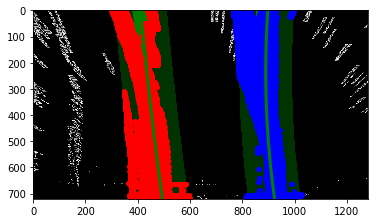

In [103]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Test On Challenge Video

2165.34541707 27680.7636097
405.21404932 m 5195.30730525 m
0.35961803978
[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


  0%|          | 1/300 [00:01<05:05,  1.02s/it]

2165.34541707 27680.7636097
405.21404932 m 5195.30730525 m
0.35961803978


  1%|          | 2/300 [00:02<05:06,  1.03s/it]

1577.09751213 18551.282161
291.479735067 m 3481.5757714 m
0.352162598969


  1%|          | 3/300 [00:03<05:17,  1.07s/it]

1278.77406515 17621.0199179
231.360051107 m 3306.89612742 m
0.345255977246


  1%|▏         | 4/300 [00:04<05:16,  1.07s/it]

1446.52935272 14816.4955845
265.373197459 m 2780.41124459 m
0.350716414985


  2%|▏         | 5/300 [00:05<05:09,  1.05s/it]

2891.99244079 66458.4367301
542.780773597 m 12470.3760716 m
0.379341409894


  2%|▏         | 6/300 [00:06<05:13,  1.07s/it]

2747.67723592 67049.3876148
515.704432536 m 12580.6701035 m
0.382135485513


  2%|▏         | 7/300 [00:07<05:27,  1.12s/it]

817.876272191 23919.9250511
120.628062214 m 4486.45091185 m
0.311130524716


  3%|▎         | 8/300 [00:08<05:15,  1.08s/it]

2082.00249542 50897.9214932
389.791161745 m 9549.02852018 m
0.374240421155


  3%|▎         | 9/300 [00:09<05:07,  1.06s/it]

2447.16728222 40984.5031252
459.07385181 m 7688.57991691 m
0.37194055753


  3%|▎         | 10/300 [00:10<05:00,  1.04s/it]

6612.3135021 18225.6186645
1234.7745604 m 3420.64236449 m
0.362723256028


  4%|▎         | 11/300 [00:11<04:57,  1.03s/it]

5900.89223645 30403.2241554
1102.58094743 m 5706.29890192 m
0.365047378048


  4%|▍         | 12/300 [00:12<04:54,  1.02s/it]

8369.37663868 18851.9824137
1521.66721937 m 3538.26452452 m
0.378180682213


  4%|▍         | 13/300 [00:13<04:53,  1.02s/it]

20056.959329 23197.1662958
3704.13935131 m 4353.8209552 m
0.351815209735


  5%|▍         | 14/300 [00:14<04:55,  1.03s/it]

30152.6892947 14602.7731954
5595.22430688 m 2740.64125008 m
0.366288814064


  5%|▌         | 15/300 [00:15<04:58,  1.05s/it]

11834.0271197 15815.9450325
2208.30265336 m 2968.44301233 m
0.356417154357


  5%|▌         | 16/300 [00:16<04:52,  1.03s/it]

8959.31239623 16622.5754549
1641.2150769 m 3119.85270661 m
0.361335572716


  6%|▌         | 17/300 [00:17<04:47,  1.02s/it]

94524.9162935 10499.3670919
17536.5547574 m 1970.33280429 m
0.349622077193


  6%|▌         | 18/300 [00:18<04:41,  1.00it/s]

4511.02685243 345515.626159
813.920959713 m 64820.7160732 m
0.361788198286


  6%|▋         | 19/300 [00:19<04:39,  1.00it/s]

7499.52515135 29079.674991
1374.83405864 m 5457.13488846 m
0.350293776296


  7%|▋         | 20/300 [00:20<04:41,  1.01s/it]

3817.58447426 27248.6170861
687.205383517 m 5112.8736246 m
0.349492316206


  7%|▋         | 21/300 [00:21<04:37,  1.00it/s]

6411.77337818 42170.2053647
1170.96041152 m 7903.90865275 m
0.363463257811


  7%|▋         | 22/300 [00:22<04:35,  1.01it/s]

5412.97267906 46660.9018004
984.121584477 m 8753.9889094 m
0.359454581893


  8%|▊         | 23/300 [00:23<04:31,  1.02it/s]

14558.2025793 12731.5909527
2682.95917991 m 2389.54325911 m
0.366672797144


  8%|▊         | 24/300 [00:24<04:32,  1.01it/s]

3500.7761471 13256.903754
622.886324774 m 2488.15615424 m
0.375227438491


  8%|▊         | 25/300 [00:25<04:30,  1.02it/s]

6599.33327888 15521.4560743
1202.27851481 m 2913.05033916 m
0.371700808628


  9%|▊         | 26/300 [00:26<04:30,  1.01it/s]

2864.14502232 37672.0082574
502.664478912 m 7067.00610716 m
0.3786812214


  9%|▉         | 27/300 [00:27<04:29,  1.01it/s]

3168.98250117 42269.3834438
566.028969175 m 7923.4019004 m
0.351232785519


  9%|▉         | 28/300 [00:28<04:32,  1.00s/it]

10722.8370169 84262.7562825
1972.95255541 m 15807.4261428 m
0.347454029745


 10%|▉         | 29/300 [00:29<04:30,  1.00it/s]

7430.4918343 88207.1011304
1389.91715833 m 16538.5626453 m
0.331655591846


 10%|█         | 30/300 [00:30<04:36,  1.02s/it]

14009.2803043 65990.4921183
2612.96288212 m 12371.2507879 m
0.335298905773


 10%|█         | 31/300 [00:31<04:52,  1.09s/it]

4646.23753829 34094.4940844
838.065524361 m 6397.19570117 m
0.36981685408


 11%|█         | 32/300 [00:33<05:01,  1.13s/it]

16604.8476359 24546.4313039
3086.36416624 m 4602.68962394 m
0.32039203257


 11%|█         | 33/300 [00:34<05:03,  1.14s/it]

5558.36050211 22696.935324
1011.74533699 m 4259.01946452 m
0.352381749166


 11%|█▏        | 34/300 [00:35<05:04,  1.15s/it]

10561.5417093 56854.2664235
1953.2301728 m 10659.5560853 m
0.329758015238


 12%|█▏        | 35/300 [00:36<05:01,  1.14s/it]

6163.65355111 86021.1699692
1133.85155367 m 16117.3727777 m
0.342414368457


 12%|█▏        | 36/300 [00:37<05:07,  1.17s/it]

29908.3174982 27297.1583647
5578.7135995 m 5118.51950783 m
0.337873865106


 12%|█▏        | 37/300 [00:39<05:04,  1.16s/it]

7275.55842851 237044.202361
1363.64708234 m 44409.9677186 m
0.319547164783


 13%|█▎        | 38/300 [00:40<05:10,  1.19s/it]

3899.81181553 32232.260375
731.88038015 m 6044.2194489 m
0.29719559055


 13%|█▎        | 39/300 [00:41<05:02,  1.16s/it]

5483.29432125 24314.9894825
1005.50705899 m 4559.28610983 m
0.342960404688


 13%|█▎        | 40/300 [00:42<05:31,  1.28s/it]

7983.03076211 22678.1371741
1478.51532764 m 4253.39613445 m
0.327517623664


 14%|█▎        | 41/300 [00:44<05:30,  1.28s/it]

12224.5364352 125276.09572
2294.39065819 m 23445.270839 m
0.288572755241


 14%|█▍        | 42/300 [00:45<05:12,  1.21s/it]

23179.7419237 11652.3445905
4333.85404828 m 2186.30353848 m
0.299076835043


 14%|█▍        | 43/300 [00:46<05:11,  1.21s/it]

239609.506884 48230.2437362
44923.3567351 m 9036.93759201 m
0.286078996752


 15%|█▍        | 44/300 [00:47<05:11,  1.22s/it]

3362.32259839 618678.524564
625.195588671 m 115774.692708 m
0.248380362165


 15%|█▌        | 45/300 [00:48<05:04,  1.19s/it]

1836.25791062 213115.048669
331.887170746 m 39919.0047411 m
0.217317678389


 15%|█▌        | 46/300 [00:49<04:47,  1.13s/it]

3304.90705578 14600.1280805
613.274048939 m 2739.0692674 m
0.233687410664


 16%|█▌        | 47/300 [00:50<04:36,  1.09s/it]

1803.6206071 23514.819985
317.542524319 m 4406.72951244 m
0.192169041516


 16%|█▌        | 48/300 [00:51<04:31,  1.08s/it]

1835.90191323 76860.0545016
321.007192372 m 14356.1590737 m
0.193501441514


 16%|█▋        | 49/300 [00:53<04:38,  1.11s/it]

2119.18786786 47314.0740495
379.54977257 m 8846.96783491 m
0.221363345063


 17%|█▋        | 50/300 [00:54<04:48,  1.16s/it]

3397.4563682 601370.147535
627.209886263 m 112334.82363 m
0.238767837221


 17%|█▋        | 51/300 [00:55<05:04,  1.22s/it]

2683.86693327 45566.3948404
490.127035438 m 8518.12164874 m
0.235871696243


 17%|█▋        | 52/300 [00:56<05:02,  1.22s/it]

1719.28245734 19952.3449096
297.966263975 m 3711.31169122 m
0.20169340223


 18%|█▊        | 53/300 [00:58<05:00,  1.22s/it]

3243.4492614 144509.90223
595.679565607 m 27014.1958967 m
0.227301510361


 18%|█▊        | 54/300 [00:59<04:48,  1.17s/it]

1873.27094467 56974.5133519
329.045112266 m 10648.8179581 m
0.201164004502


 18%|█▊        | 55/300 [01:00<04:43,  1.16s/it]

1548.18314894 54916.273973
262.837865882 m 10235.0107563 m
0.20265430981


 19%|█▊        | 56/300 [01:01<04:34,  1.12s/it]

1743.86588209 45962.0762571
303.966327178 m 8556.38146517 m
0.21956773865


 19%|█▉        | 57/300 [01:02<04:27,  1.10s/it]

1570.20909737 9064.81390426
268.613259215 m 1679.01299585 m
0.207371492378


 19%|█▉        | 58/300 [01:03<04:43,  1.17s/it]

1438.21119874 709061.44558
244.702238265 m 132399.245894 m
0.216693901999


 20%|█▉        | 59/300 [01:04<04:46,  1.19s/it]

1363.7637003 45200.2767016
229.191485178 m 8437.92968515 m
0.201939968732


 20%|██        | 60/300 [01:06<04:48,  1.20s/it]

1512.74721269 12775.8991623
258.213126446 m 2370.50522877 m
0.219245126552


 20%|██        | 61/300 [01:07<04:42,  1.18s/it]

1592.01994463 7494.06544685
275.211768495 m 1380.75250311 m
0.23290620485


 21%|██        | 62/300 [01:08<04:40,  1.18s/it]

1589.95152183 5897.20746456
274.267196938 m 1079.37643625 m
0.241662315159


 21%|██        | 63/300 [01:09<04:36,  1.17s/it]

1532.69951987 4241.79568069
263.402250321 m 768.271200392 m
0.259184896777


 21%|██▏       | 64/300 [01:10<04:35,  1.17s/it]

1385.47204949 3692.88588314
232.432373351 m 661.643577709 m
0.265228604781


 22%|██▏       | 65/300 [01:11<04:33,  1.16s/it]

1230.06467788 3015.45198152
200.319026476 m 533.356310432 m
0.264569375433


 22%|██▏       | 66/300 [01:13<04:24,  1.13s/it]

1299.02708514 3445.02351014
217.133221568 m 617.983720111 m
0.268177023666


 22%|██▏       | 67/300 [01:14<04:19,  1.12s/it]

1454.7404438 3524.88462415
250.542314508 m 635.01567238 m
0.2747706412


 23%|██▎       | 68/300 [01:15<04:21,  1.13s/it]

1536.98069015 3679.98103624
267.892335584 m 665.179090085 m
0.278654778864


 23%|██▎       | 69/300 [01:16<04:14,  1.10s/it]

1886.40541778 3948.40562848
340.050558927 m 718.21542734 m
0.288784715663


 23%|██▎       | 70/300 [01:17<04:19,  1.13s/it]

1507.52840688 3224.93759745
264.262864404 m 577.372300147 m
0.306486548059


 24%|██▎       | 71/300 [01:18<04:16,  1.12s/it]

1774.35472319 8886.35216578
318.905771235 m 1664.10789217 m
0.180454664395


 24%|██▍       | 72/300 [01:19<04:18,  1.13s/it]

1764.43594016 7642.2216858
316.797479641 m 1429.85302573 m
0.177096942398


 24%|██▍       | 73/300 [01:20<04:12,  1.11s/it]

1693.17694442 7335.87347416
303.017323483 m 1372.58508727 m
0.180246596299


 25%|██▍       | 74/300 [01:21<04:14,  1.13s/it]

1679.44672911 7652.90096401
300.267936908 m 1431.97102538 m
0.181140386511


 25%|██▌       | 75/300 [01:23<04:08,  1.11s/it]

2009.83896898 8465.64981048
366.49678723 m 1585.05294404 m
0.195156808953


 25%|██▌       | 76/300 [01:24<04:06,  1.10s/it]

1922.32223906 9136.43395632
349.810167602 m 1711.74708022 m
0.203916490554


 26%|██▌       | 77/300 [01:25<04:04,  1.10s/it]

1803.53434824 8116.27719112
326.388187124 m 1520.41634003 m
0.205644135732


 26%|██▌       | 78/300 [01:26<04:04,  1.10s/it]

1745.41120022 10432.9874381
315.112445698 m 1956.22222452 m
0.211475036948


 26%|██▋       | 79/300 [01:27<04:04,  1.11s/it]

1882.99707562 9254.71218887
342.985539824 m 1734.35568935 m
0.216597730496


 27%|██▋       | 80/300 [01:28<04:02,  1.10s/it]

1913.24178473 7868.15687635
349.140797446 m 1473.34352018 m
0.215793609101


 27%|██▋       | 81/300 [01:29<03:57,  1.08s/it]

1980.75594519 9987.16986797
362.937952641 m 1872.65974048 m
0.227876037662


 27%|██▋       | 82/300 [01:30<03:57,  1.09s/it]

1637.654839 8213.50459586
293.849752698 m 1537.97190892 m
0.205788230183


 28%|██▊       | 83/300 [01:31<03:54,  1.08s/it]

1608.88464504 7415.5876166
287.57244181 m 1387.78739752 m
0.200395624918


 28%|██▊       | 84/300 [01:32<03:51,  1.07s/it]

1515.91513932 8203.91126219
268.356213114 m 1536.92769087 m
0.200772613861


 28%|██▊       | 85/300 [01:33<03:51,  1.08s/it]

1558.46345403 8663.48598685
277.579647599 m 1623.0330797 m
0.206884743054


 29%|██▊       | 86/300 [01:34<03:50,  1.08s/it]

1667.92445935 10788.1677006
300.006358445 m 2022.99835633 m
0.217518500302


 29%|██▉       | 87/300 [01:36<03:50,  1.08s/it]

1950.57808378 9185.45477365
356.905686665 m 1721.52626186 m
0.227637665263


 29%|██▉       | 88/300 [01:37<03:52,  1.09s/it]

1938.84316148 8602.87420317
355.268419278 m 1611.69370155 m
0.231535260465


 30%|██▉       | 89/300 [01:38<03:49,  1.09s/it]

1713.18449961 12399.0141973
310.696557507 m 2325.0787189 m
0.231228962433


 30%|███       | 90/300 [01:39<03:44,  1.07s/it]

1642.9273193 11421.0613505
296.211193387 m 2141.88085297 m
0.228255305584


 30%|███       | 91/300 [01:40<03:41,  1.06s/it]

1887.04988764 10585.8276591
345.238526026 m 1984.97617006 m
0.239220028411


 31%|███       | 92/300 [01:41<03:40,  1.06s/it]

1766.86708964 8275.04212746
321.433416655 m 1550.25544553 m
0.234138657799


 31%|███       | 93/300 [01:42<03:38,  1.05s/it]

1666.66421725 8736.08258313
300.940236119 m 1636.93642916 m
0.226889103462


 31%|███▏      | 94/300 [01:43<03:45,  1.09s/it]

1547.32156467 8041.68764078
276.896019289 m 1506.24615972 m
0.224002166223


 32%|███▏      | 95/300 [01:44<03:47,  1.11s/it]

1567.00281327 6395.6284345
281.610922319 m 1195.7089574 m
0.224944215371


 32%|███▏      | 96/300 [01:45<03:47,  1.11s/it]

1662.16295123 6201.1939532
301.936642259 m 1158.99758225 m
0.229609019054


 32%|███▏      | 97/300 [01:46<03:47,  1.12s/it]

1349.44416033 5808.98061472
242.640417453 m 1085.32735315 m
0.233664459533


 33%|███▎      | 98/300 [01:48<03:41,  1.10s/it]

1341.83602902 4288.15248322
242.169168463 m 798.692167724 m
0.234975139911


 33%|███▎      | 99/300 [01:49<03:38,  1.09s/it]

1316.13743429 4576.55883625
238.597355276 m 854.471559641 m
0.244532319361


 33%|███▎      | 100/300 [01:50<03:36,  1.08s/it]

1450.93308751 3389.38556885
263.670160258 m 629.440692479 m
0.233001092463


 34%|███▎      | 101/300 [01:51<03:36,  1.09s/it]

2294.37894042 2932.18393652
426.736781524 m 541.691352778 m
0.242309715584


 34%|███▍      | 102/300 [01:52<03:47,  1.15s/it]

2340.25121049 2713.95847142
435.044522452 m 499.308761815 m
0.235046072047


 34%|███▍      | 103/300 [01:53<03:47,  1.15s/it]

2238.03821207 3024.11528479
415.017377165 m 558.870728174 m
0.236146797858


 35%|███▍      | 104/300 [01:54<03:43,  1.14s/it]

2608.45354082 12179.2742691
485.485632264 m 2283.17342642 m
0.268993456225


 35%|███▌      | 105/300 [01:56<03:45,  1.16s/it]

2541.24631252 14706.5838711
472.417026541 m 2757.62370136 m
0.268036871631


 35%|███▌      | 106/300 [01:57<03:40,  1.14s/it]

2506.03854352 30037.9799382
465.176775592 m 5635.83979684 m
0.257319522111


 36%|███▌      | 107/300 [01:58<03:35,  1.12s/it]

2278.37021381 51267.4768566
420.852600984 m 9620.94501693 m
0.247124805409


 36%|███▌      | 108/300 [01:59<03:36,  1.13s/it]

2795.34263665 33310.8206223
520.368175822 m 6251.74503322 m
0.245390276512


 36%|███▋      | 109/300 [02:00<03:29,  1.10s/it]

2854.46041689 16518.6622965
532.042293597 m 3099.39861433 m
0.246381328211


 37%|███▋      | 110/300 [02:01<03:24,  1.08s/it]

3938.66500488 11821.0669556
737.995384663 m 2217.03819832 m
0.25039737919


 37%|███▋      | 111/300 [02:02<03:24,  1.08s/it]

5098.26023148 10663.3919748
956.712336013 m 1999.25093851 m
0.256011597779


 37%|███▋      | 112/300 [02:03<03:21,  1.07s/it]

7203.54244371 13521.6218123
1351.99007433 m 2536.04215232 m
0.252090893012


 38%|███▊      | 113/300 [02:04<03:22,  1.08s/it]

12653.6651941 4835.61225575
2372.69950474 m 901.767240083 m
0.243577393184


 38%|███▊      | 114/300 [02:05<03:19,  1.07s/it]

11579.2015805 10800.6345646
2172.02385484 m 2024.42420576 m
0.249005485009


 38%|███▊      | 115/300 [02:06<03:17,  1.07s/it]

16774.0479676 12559.1196351
3143.56167617 m 2355.30388865 m
0.257824412309


 39%|███▊      | 116/300 [02:07<03:16,  1.07s/it]

22699.9014802 17302.5423424
4253.17464654 m 3246.90448027 m
0.259547522742


 39%|███▉      | 117/300 [02:08<03:12,  1.05s/it]

81488.92104 10382.4887084
15253.3007231 m 1945.86248319 m
0.25161198755


 39%|███▉      | 118/300 [02:11<04:18,  1.42s/it]

19014.6051831 17912.5221493
3542.36142144 m 3361.07595922 m
0.272224562858


 40%|███▉      | 119/300 [02:12<04:04,  1.35s/it]

8544.14178432 18140.415157
1580.45127956 m 3403.91266518 m
0.2864701545


 40%|████      | 120/300 [02:13<03:46,  1.26s/it]

6170.2227362 25788.7084116
1137.18780049 m 4839.92232147 m
0.283687434065


 40%|████      | 121/300 [02:14<03:37,  1.21s/it]

6447.71354876 403713.055747
1190.71698826 m 75766.0277187 m
0.280142594578


 41%|████      | 122/300 [02:15<03:29,  1.18s/it]

5729.43116215 96630.003369
1056.18841147 m 18135.8397351 m
0.278056620815


 41%|████      | 123/300 [02:16<03:19,  1.13s/it]

4874.02309214 27508.8319104
894.961390144 m 5162.49316369 m
0.275765176924


 41%|████▏     | 124/300 [02:17<03:13,  1.10s/it]

5118.83919135 18229.9477944
942.964583831 m 3420.21150645 m
0.263552729275


 42%|████▏     | 125/300 [02:18<03:09,  1.08s/it]

4642.71777189 5670.40954137
853.4531442 m 1058.77304832 m
0.250017681581


 42%|████▏     | 126/300 [02:19<03:06,  1.07s/it]

4718.79559807 12033.1545336
868.604783907 m 2256.40670926 m
0.257164800688


 42%|████▏     | 127/300 [02:20<03:04,  1.07s/it]

4657.84562688 10484.1576502
857.597586368 m 1965.25774113 m
0.253686084699


 43%|████▎     | 128/300 [02:21<03:03,  1.07s/it]

4706.94912181 10222.907782
867.231298048 m 1915.94579001 m
0.250841018503


 43%|████▎     | 129/300 [02:22<03:02,  1.07s/it]

4951.99871083 9993.80899661
914.316006787 m 1872.87904012 m
0.245408132067


 43%|████▎     | 130/300 [02:23<03:00,  1.06s/it]

5576.45909344 8191.62484139
1033.33786257 m 1533.57348529 m
0.234737487923


 44%|████▎     | 131/300 [02:25<03:10,  1.12s/it]

5325.08453467 10227.4282229
985.729326418 m 1917.24699329 m
0.243058151857


 44%|████▍     | 132/300 [02:26<03:12,  1.14s/it]

5784.93304829 11425.8983321
1073.10324137 m 2142.62891683 m
0.241198101133


 44%|████▍     | 133/300 [02:27<03:09,  1.14s/it]

6489.24633982 7417.22581916
1206.57792606 m 1389.60024598 m
0.233888397869


 45%|████▍     | 134/300 [02:28<03:05,  1.12s/it]

24036.8584209 19150.3902225
4511.24872331 m 3593.90500296 m
0.219998230675


 45%|████▌     | 135/300 [02:29<03:08,  1.14s/it]

8529.62431367 20852.3614329
1600.03156716 m 3913.48105517 m
0.219144237684


 45%|████▌     | 136/300 [02:31<03:12,  1.18s/it]

3524.3183735 13823.7746533
656.164122082 m 2593.86214586 m
0.213629518413


 46%|████▌     | 137/300 [02:32<03:12,  1.18s/it]

1860.7937383 9532.13433941
331.615634793 m 1787.08757899 m
0.162630984964


 46%|████▌     | 138/300 [02:33<03:09,  1.17s/it]

1276.23271531 14476.6329056
206.950530232 m 2716.2575499 m
0.122552836989


 46%|████▋     | 139/300 [02:34<03:11,  1.19s/it]

1139.65739939 15768.1479408
175.040715182 m 2958.85670455 m
0.114056584736


 47%|████▋     | 140/300 [02:35<03:15,  1.22s/it]

1345.6301351 6936.58251751
229.083928115 m 1299.36017152 m
0.172783333298


 47%|████▋     | 141/300 [02:37<03:14,  1.23s/it]

1239.51818672 5343.44587633
207.983054381 m 999.009449074 m
0.178916731865


 47%|████▋     | 142/300 [02:38<03:15,  1.24s/it]

1301.57389279 8532.76758085
223.433450566 m 1599.73110091 m
0.204051944488


 48%|████▊     | 143/300 [02:39<03:10,  1.21s/it]

1426.40262302 3982.29695073
251.88892703 m 741.589106448 m
0.211609057759


 48%|████▊     | 144/300 [02:40<03:06,  1.20s/it]

1274.47547311 5326.25515027
218.920773961 m 995.273506252 m
0.205284461253


 48%|████▊     | 145/300 [02:41<03:02,  1.18s/it]

1183.17225073 3295.0991698
199.420369226 m 610.511853087 m
0.183128280773


 49%|████▊     | 146/300 [02:43<03:04,  1.20s/it]

1183.37460301 9467.06000262
195.012653085 m 1773.99903019 m
0.180609842086


 49%|████▉     | 147/300 [02:44<03:12,  1.26s/it]

1133.77957129 9872.53638298
182.129083815 m 1850.40152378 m
0.169465805333


 49%|████▉     | 148/300 [02:45<03:02,  1.20s/it]

1101.60093048 9913.49644518
174.112849957 m 1858.21257844 m
0.165317139699


 50%|████▉     | 149/300 [02:46<02:55,  1.16s/it]

1185.94410225 14551.8280608
195.332717137 m 2729.63098597 m
0.180870214724


 50%|█████     | 150/300 [02:47<02:50,  1.14s/it]

1126.32950206 9951.40052494
181.349941711 m 1865.55204034 m
0.172736686339


 50%|█████     | 151/300 [02:48<02:45,  1.11s/it]

1247.79924298 3578.65528103
212.17238649 m 664.409674977 m
0.185363601247


 51%|█████     | 152/300 [02:49<02:42,  1.10s/it]

1262.42468464 2282.78330449
215.568516255 m 417.198755786 m
0.17288467424


 51%|█████     | 153/300 [02:50<02:39,  1.09s/it]

1338.45032393 1852.86394899
232.690193108 m 333.889069833 m
0.172388125926


 51%|█████▏    | 154/300 [02:51<02:38,  1.09s/it]

1205.24277039 2263.16529409
202.10979196 m 413.602792254 m
0.16245582556


 52%|█████▏    | 155/300 [02:53<02:36,  1.08s/it]

1132.34864886 3046.89209344
184.090808479 m 563.59536508 m
0.158498286435


 52%|█████▏    | 156/300 [02:54<02:45,  1.15s/it]

1076.58481612 2624.6267097
170.238804096 m 482.810266748 m
0.145856536711


 52%|█████▏    | 157/300 [02:55<02:40,  1.12s/it]

1153.66767405 5302.30044048
189.225398552 m 990.43893073 m
0.172940281768


 53%|█████▎    | 158/300 [02:56<02:38,  1.11s/it]

1093.33129548 2499.75415968
175.518865369 m 459.177152047 m
0.153986349071


 53%|█████▎    | 159/300 [02:57<02:34,  1.10s/it]

1099.55601999 2673.15382244
176.508147345 m 492.056818828 m
0.153348244702


 53%|█████▎    | 160/300 [02:58<02:30,  1.08s/it]

1165.03818421 2910.72153526
193.144553023 m 537.643183717 m
0.171427316669


 54%|█████▎    | 161/300 [02:59<02:29,  1.07s/it]

1106.86228776 3808.68056034
179.228713949 m 709.001239574 m
0.176046736439


 54%|█████▍    | 162/300 [03:00<02:27,  1.07s/it]

1106.9357324 2714.76585024
179.96346591 m 500.574113067 m
0.169521839015


 54%|█████▍    | 163/300 [03:01<02:27,  1.08s/it]

1138.77504118 4214.15940437
188.062312 m 785.108803896 m
0.186233873697


 55%|█████▍    | 164/300 [03:02<02:26,  1.08s/it]

1109.48403183 8139.22111152
179.461864186 m 1524.99720014 m
0.183638947101


 55%|█████▌    | 165/300 [03:03<02:24,  1.07s/it]

1187.08826856 3368.88829146
199.356393113 m 625.043871978 m
0.185376822638


 55%|█████▌    | 166/300 [03:05<02:23,  1.07s/it]

1131.58898409 2395.54826483
185.88530708 m 439.262856812 m
0.164854708259


 56%|█████▌    | 167/300 [03:06<02:25,  1.10s/it]

1131.03900201 2530.10488948
185.033754595 m 464.740357661 m
0.160428834795


 56%|█████▌    | 168/300 [03:07<02:31,  1.15s/it]

1154.12036364 2734.84933513
191.634903376 m 504.641062359 m
0.175712232823


 56%|█████▋    | 169/300 [03:08<02:31,  1.16s/it]

1207.10110608 2506.74656618
204.238984927 m 460.776617398 m
0.178588221269


 57%|█████▋    | 170/300 [03:09<02:36,  1.20s/it]

1375.87114794 2866.54473454
243.420837154 m 530.196627475 m
0.209503423431


 57%|█████▋    | 171/300 [03:11<02:40,  1.24s/it]

1341.47137815 4050.49087165
236.643188862 m 754.706342932 m
0.214698122657


 57%|█████▋    | 172/300 [03:12<02:35,  1.22s/it]

1435.75500079 3980.55932445
254.25896204 m 741.619295216 m
0.211583608513


 58%|█████▊    | 173/300 [03:13<02:38,  1.25s/it]

1508.33271109 3858.64736482
270.077115914 m 717.955889681 m
0.220357016889


 58%|█████▊    | 174/300 [03:15<02:38,  1.26s/it]

1633.30782158 3147.84468443
295.289522096 m 583.461763884 m
0.22040615701


 58%|█████▊    | 175/300 [03:16<02:37,  1.26s/it]

1506.97156016 10407.1825802
268.05852415 m 1951.59660075 m
0.219374014536


 59%|█████▊    | 176/300 [03:17<02:30,  1.21s/it]

1459.82416555 4663.67002622
258.834130673 m 870.240713443 m
0.202696830072


 59%|█████▉    | 177/300 [03:18<02:23,  1.17s/it]

1406.47112125 3582.71274541
245.931199172 m 665.286498083 m
0.186734593311


 59%|█████▉    | 178/300 [03:19<02:21,  1.16s/it]

1558.51332533 7115.14305921
278.448244538 m 1331.92424342 m
0.212716838991


 60%|█████▉    | 179/300 [03:20<02:16,  1.13s/it]

1661.54141748 7358.68830541
299.033653855 m 1377.81181168 m
0.212634750221


 60%|██████    | 180/300 [03:21<02:11,  1.10s/it]

1536.37033518 7096.14194911
273.102252262 m 1328.35424588 m
0.204127161138


 60%|██████    | 181/300 [03:22<02:07,  1.07s/it]

1319.13102657 3298.14664348
226.354454887 m 611.072285412 m
0.170999116837


 61%|██████    | 182/300 [03:23<02:05,  1.06s/it]

1447.02927578 7928.97743046
254.413567561 m 1484.81690121 m
0.198346144737


 61%|██████    | 183/300 [03:24<02:03,  1.06s/it]

1360.560398 6290.26158457
236.972891878 m 1176.24664259 m
0.19707916124


 61%|██████▏   | 184/300 [03:25<02:01,  1.05s/it]

1318.11806346 7730.29889426
227.033909783 m 1446.95502017 m
0.190102375274


 62%|██████▏   | 185/300 [03:26<02:00,  1.05s/it]

1329.17413004 8124.27120015
230.386282301 m 1521.72520318 m
0.201452854289


 62%|██████▏   | 186/300 [03:27<01:58,  1.04s/it]

1385.12603029 11155.5745239
242.02465823 m 2091.10967884 m
0.204280428003


 62%|██████▏   | 187/300 [03:28<01:56,  1.03s/it]

1430.04977011 5626.912813
252.19744567 m 1052.12354112 m
0.208711539643


 63%|██████▎   | 188/300 [03:29<01:55,  1.03s/it]

1667.97925136 7222.93443032
301.029276026 m 1352.74948014 m
0.222188474895


 63%|██████▎   | 189/300 [03:30<01:53,  1.03s/it]

1214.70568186 7967.55813302
209.005444555 m 1493.40587286 m
0.209389322961


 63%|██████▎   | 190/300 [03:31<01:51,  1.01s/it]

1202.6888099 9981.50858279
207.213778454 m 1871.74935235 m
0.206019259053


 64%|██████▎   | 191/300 [03:32<01:50,  1.01s/it]

1570.57906086 13666.3116627
280.701816853 m 2563.21209551 m
0.215041086672


 64%|██████▍   | 192/300 [03:33<01:50,  1.03s/it]

1525.96248139 9536.54842274
271.254296866 m 1787.50543069 m
0.209711618459


 64%|██████▍   | 193/300 [03:35<01:49,  1.03s/it]

1776.28734862 11277.9246429
321.999241492 m 2114.83996587 m
0.218295705441


 65%|██████▍   | 194/300 [03:36<01:48,  1.03s/it]

1666.2778225 11225.1196683
300.905141011 m 2105.39424796 m
0.226711088384


 65%|██████▌   | 195/300 [03:37<01:47,  1.02s/it]

1709.77436731 14971.2807393
309.321197573 m 2808.54676856 m
0.223034541441


 65%|██████▌   | 196/300 [03:38<01:49,  1.05s/it]

1864.15920216 11058.401842
340.68500234 m 2073.2077218 m
0.229407946634


 66%|██████▌   | 197/300 [03:39<01:47,  1.04s/it]

1768.31768056 9621.06340944
322.312634888 m 1804.49750102 m
0.238442250237


 66%|██████▌   | 198/300 [03:40<01:46,  1.04s/it]

1705.0512295 9410.44256339
311.127802253 m 1764.06596404 m
0.247052347817


 66%|██████▋   | 199/300 [03:41<01:44,  1.04s/it]

1577.91041808 7917.96584625
284.749775085 m 1484.84458996 m
0.234625498599


 67%|██████▋   | 200/300 [03:42<01:44,  1.04s/it]

1745.31144711 9517.49195545
317.455472274 m 1785.12568961 m
0.234021135842


 67%|██████▋   | 201/300 [03:43<01:48,  1.10s/it]

1466.42889148 8072.81763519
263.536870531 m 1513.74831986 m
0.23590812543


 67%|██████▋   | 202/300 [03:44<01:49,  1.12s/it]

1580.90383022 13678.6219306
285.674867148 m 2567.07260396 m
0.231524282325


 68%|██████▊   | 203/300 [03:45<01:45,  1.09s/it]

1385.77068615 14481.3461127
248.319778811 m 2717.4965925 m
0.228722046523


 68%|██████▊   | 204/300 [03:46<01:42,  1.06s/it]

1763.82939761 17175.9919033
324.160594555 m 3223.57822373 m
0.255487480662


 68%|██████▊   | 205/300 [03:47<01:40,  1.06s/it]

2792.90557101 18118.5157604
520.727092133 m 3400.14228927 m
0.259563915379


 69%|██████▊   | 206/300 [03:48<01:38,  1.05s/it]

5107.7642167 14107.7996818
958.19297424 m 2645.91354063 m
0.257355978068


 69%|██████▉   | 207/300 [03:49<01:36,  1.04s/it]

2845.17182949 14340.5578859
530.805487316 m 2689.61517008 m
0.257073590252


 69%|██████▉   | 208/300 [03:50<01:36,  1.05s/it]

1476.89824739 12740.7420345
263.958531549 m 2390.73392218 m
0.226201936266


 70%|██████▉   | 209/300 [03:51<01:35,  1.05s/it]

1787.25739077 8660.28369087
324.829072784 m 1622.78463694 m
0.22127737578


 70%|███████   | 210/300 [03:52<01:34,  1.05s/it]

1815.36759637 8972.02906526
329.685968257 m 1681.55883998 m
0.213855954777


 70%|███████   | 211/300 [03:54<01:32,  1.04s/it]

1480.68291502 10819.8572641
263.870969845 m 2027.75559478 m
0.210789955787


 71%|███████   | 212/300 [03:55<01:34,  1.07s/it]

1085.39456185 9844.08554618
182.477460724 m 1844.08944727 m
0.185150769082


 71%|███████   | 213/300 [03:56<01:33,  1.08s/it]

1140.4813523 11694.9130688
196.333487216 m 2192.24171194 m
0.20029300812


 71%|███████▏  | 214/300 [03:57<01:32,  1.07s/it]

1169.37698954 15284.9853508
200.478942567 m 2867.11027482 m
0.198224166774


 72%|███████▏  | 215/300 [03:58<01:29,  1.05s/it]

1009.43284613 20685.4087828
166.916804391 m 3881.96270609 m
0.202278370778


 72%|███████▏  | 216/300 [03:59<01:31,  1.08s/it]

1326.53584073 18331.3687817
233.046102433 m 3439.67337098 m
0.214918766262


 72%|███████▏  | 217/300 [04:00<01:31,  1.10s/it]

1097.35379786 16865.6401762
185.85180251 m 3164.14368554 m
0.199673656096


 73%|███████▎  | 218/300 [04:01<01:35,  1.16s/it]

1584.81563465 15568.2239944
285.961022711 m 2920.4229601 m
0.225515374978


 73%|███████▎  | 219/300 [04:03<01:35,  1.17s/it]

1824.56482267 14801.6455006
333.352579459 m 2776.81867456 m
0.23099806416


 73%|███████▎  | 220/300 [04:04<01:32,  1.15s/it]

1710.93769139 11983.285588
309.609669394 m 2247.25074033 m
0.222074441619


 74%|███████▎  | 221/300 [04:05<01:30,  1.14s/it]

1980.95541398 13297.3216745
362.476690467 m 2493.62783739 m
0.21930812155


 74%|███████▍  | 222/300 [04:06<01:29,  1.15s/it]

1840.43893253 12088.9430038
334.573366901 m 2266.51610052 m
0.214077766663


 74%|███████▍  | 223/300 [04:07<01:25,  1.11s/it]

1900.7852804 11759.2523351
346.26503721 m 2204.53064115 m
0.211934016323


 75%|███████▍  | 224/300 [04:08<01:23,  1.09s/it]

1493.57217287 11331.2569578
265.408752238 m 2123.92773838 m
0.195442642841


 75%|███████▌  | 225/300 [04:09<01:20,  1.07s/it]

1331.53086421 17481.4958989
235.19760945 m 3278.49525297 m
0.201031982804


 75%|███████▌  | 226/300 [04:10<01:18,  1.06s/it]

1789.72205848 10683.493902
326.222514404 m 2001.99475867 m
0.21737153426


 76%|███████▌  | 227/300 [04:11<01:17,  1.06s/it]

1761.26418624 13151.3672271
321.341871002 m 2466.16107949 m
0.216702651912


 76%|███████▌  | 228/300 [04:12<01:15,  1.05s/it]

1543.06893519 15945.9709853
279.345042284 m 2991.29691147 m
0.217787027418


 76%|███████▋  | 229/300 [04:13<01:13,  1.04s/it]

1477.83804827 30085.8616395
267.320708644 m 5645.98729682 m
0.233067357106


 77%|███████▋  | 230/300 [04:14<01:12,  1.03s/it]

1392.1004638 21096.1441191
249.972894757 m 3958.47154315 m
0.223100486763


 77%|███████▋  | 231/300 [04:15<01:10,  1.02s/it]

1577.41010182 19065.670716
286.057413861 m 3577.16902179 m
0.220743988095


 77%|███████▋  | 232/300 [04:16<01:09,  1.03s/it]

1437.3826852 17722.385831
254.658050997 m 3324.92957534 m
0.203165048565


 78%|███████▊  | 233/300 [04:17<01:08,  1.03s/it]

2837.26167716 16323.0366457
528.386509186 m 3061.93868202 m
0.239243846251


 78%|███████▊  | 234/300 [04:18<01:07,  1.02s/it]

1625.65331894 14527.901696
292.868658509 m 2724.69916359 m
0.208030077271


 78%|███████▊  | 235/300 [04:19<01:06,  1.03s/it]

1163.49688538 14511.1241761
198.113831137 m 2721.46955421 m
0.191294968907


 79%|███████▊  | 236/300 [04:20<01:06,  1.04s/it]

1552.67417189 13191.6644817
277.611161826 m 2473.61422642 m
0.202408852742


 79%|███████▉  | 237/300 [04:21<01:04,  1.03s/it]

1185.00238817 10776.6538292
204.745651309 m 2019.63015474 m
0.195832954604


 79%|███████▉  | 238/300 [04:22<01:04,  1.03s/it]

1202.98275713 10515.5603072
209.304435695 m 1970.27418444 m
0.193933043299


 80%|███████▉  | 239/300 [04:24<01:03,  1.03s/it]

1049.49027397 10165.4020588
178.330261083 m 1904.371726 m
0.195964860877


 80%|████████  | 240/300 [04:25<01:02,  1.04s/it]

980.796270136 11455.937206
164.001308877 m 2147.30275014 m
0.191140995541


 80%|████████  | 241/300 [04:26<01:01,  1.05s/it]

953.880701234 751860.427722
157.814785189 m 141114.945071 m
0.19992715345


 81%|████████  | 242/300 [04:27<00:59,  1.03s/it]

927.252278979 15190.4963588
147.879288276 m 2848.44887984 m
0.200254793057


 81%|████████  | 243/300 [04:28<00:57,  1.01s/it]

965.949792928 8223.45784217
157.566402859 m 1538.74758858 m
0.217702739477


 81%|████████▏ | 244/300 [04:29<01:00,  1.08s/it]

1025.7405822 16004.9318778
170.750877119 m 3001.84352103 m
0.217558328361


 82%|████████▏ | 245/300 [04:30<01:01,  1.11s/it]

1303.12545227 11886.0714485
228.513129388 m 2229.47752642 m
0.214230567248


 82%|████████▏ | 246/300 [04:31<01:01,  1.15s/it]

1361.20130191 11347.3955384
240.560572867 m 2127.78574002 m
0.218688471218


 82%|████████▏ | 247/300 [04:33<01:03,  1.20s/it]

1516.63674519 322048.351963
271.539017297 m 60434.9615213 m
0.242348067331


 83%|████████▎ | 248/300 [04:34<00:59,  1.15s/it]

2085.40825232 11319.7826885
383.672358726 m 2122.68941237 m
0.241236710547


 83%|████████▎ | 249/300 [04:35<00:56,  1.11s/it]

1723.5258748 18424.0281416
313.642974036 m 3457.70620147 m
0.245119507296


 83%|████████▎ | 250/300 [04:36<00:53,  1.08s/it]

1911.82435227 22387.1311621
350.470626841 m 4199.0136243 m
0.252100766061


 84%|████████▎ | 251/300 [04:37<00:51,  1.05s/it]

2597.45236431 11618.896666
483.823997774 m 2177.9614283 m
0.256361425444


 84%|████████▍ | 252/300 [04:38<00:49,  1.04s/it]

2122.49292377 16109.1449485
392.414666367 m 3021.35341429 m
0.262637779193


 84%|████████▍ | 253/300 [04:39<00:48,  1.04s/it]

2582.52442507 71067.4152383
481.507665585 m 13338.4744887 m
0.266790127238


 85%|████████▍ | 254/300 [04:40<00:47,  1.03s/it]

3604.61480963 10858.2822878
674.945335089 m 2034.20062197 m
0.288765005413


 85%|████████▌ | 255/300 [04:41<00:47,  1.05s/it]

2268.85273471 22635.0608885
421.074198948 m 4245.50607676 m
0.269555377134


 85%|████████▌ | 256/300 [04:42<00:46,  1.05s/it]

1981.22561074 20719.9711875
364.498576907 m 3884.83052048 m
0.26511524222


 86%|████████▌ | 257/300 [04:43<00:45,  1.05s/it]

1616.22980052 8099.41275222
291.494999675 m 1510.34391244 m
0.268959003451


 86%|████████▌ | 258/300 [04:44<00:43,  1.05s/it]

1705.2400745 10048.2465235
308.824695972 m 1880.49117913 m
0.253459003239


 86%|████████▋ | 259/300 [04:45<00:42,  1.05s/it]

1236.35710693 8998.80558992
213.584601787 m 1681.20127237 m
0.23453934528


 87%|████████▋ | 260/300 [04:46<00:42,  1.05s/it]

1681.73932301 14414.0023466
304.598630928 m 2702.54304954 m
0.24204657922


 87%|████████▋ | 261/300 [04:47<00:41,  1.06s/it]

1949.75054757 8478.35357586
357.656113692 m 1586.53347309 m
0.258765956967


 87%|████████▋ | 262/300 [04:48<00:39,  1.04s/it]

1481.9518011 8965.23460201
266.198221879 m 1676.83814632 m
0.251335188132


 88%|████████▊ | 263/300 [04:49<00:37,  1.02s/it]

1363.64156761 19824.9759848
244.039314277 m 3719.69506968 m
0.239993848088


 88%|████████▊ | 264/300 [04:50<00:36,  1.02s/it]

1355.41319329 46444.2371069
243.212551853 m 8716.17777569 m
0.231464618211


 88%|████████▊ | 265/300 [04:51<00:35,  1.02s/it]

1104.79921519 40127.2507363
191.84270381 m 7530.08286726 m
0.214179557385


 89%|████████▊ | 266/300 [04:52<00:35,  1.04s/it]

1948.62300845 41965.1322597
358.995235303 m 7876.0000477 m
0.249676798755


 89%|████████▉ | 267/300 [04:54<00:37,  1.14s/it]

1151.97760054 17840.9743794
200.981615481 m 3344.67682157 m
0.235109337059


 89%|████████▉ | 268/300 [04:55<00:38,  1.20s/it]

1698.19667341 123585.834818
309.75173709 m 23193.8809742 m
0.246410529634


 90%|████████▉ | 269/300 [04:56<00:38,  1.26s/it]

1539.27787641 13764.2840893
276.821101312 m 2582.78058015 m
0.227845977839


 90%|█████████ | 270/300 [04:58<00:38,  1.28s/it]

1485.71560287 11315.5959199
266.458519278 m 2122.60765219 m
0.227031218401


 90%|█████████ | 271/300 [04:59<00:36,  1.25s/it]

1383.89412524 20709.2947636
245.990268235 m 3886.73821418 m
0.224970863448


 91%|█████████ | 272/300 [05:00<00:35,  1.26s/it]

1158.27565347 9568.85593001
201.318196359 m 1789.14559843 m
0.240998027196


 91%|█████████ | 273/300 [05:01<00:34,  1.27s/it]

1097.62062862 29201.96982
189.615731224 m 5476.08475499 m
0.23000962714


 91%|█████████▏| 274/300 [05:03<00:33,  1.27s/it]

1152.93591475 12697.5260969
204.455836547 m 2377.11067438 m
0.251341235112


 92%|█████████▏| 275/300 [05:04<00:31,  1.28s/it]

1536.796874 3782.81620883
284.302637987 m 699.737998502 m
0.298745100893


 92%|█████████▏| 276/300 [05:05<00:31,  1.30s/it]

2645.05686316 3381.99750548
496.12079592 m 622.772385802 m
0.32171435603


 92%|█████████▏| 277/300 [05:07<00:29,  1.30s/it]

6225.98228123 3172.57637756
1167.00144805 m 583.230314391 m
0.333018460461


 93%|█████████▎| 278/300 [05:08<00:28,  1.30s/it]

9681.98473374 2813.00687653
1766.03759729 m 514.831015198 m
0.36580300996


 93%|█████████▎| 279/300 [05:09<00:26,  1.27s/it]

4228.32986412 4658.39484216
793.498932861 m 865.971720086 m
0.308041778613


 93%|█████████▎| 280/300 [05:10<00:25,  1.26s/it]

22251.4288199 4244.86166416
4155.60319421 m 788.102101298 m
0.327190298753


 94%|█████████▎| 281/300 [05:12<00:23,  1.25s/it]

4118.96754738 5057.86898399
773.077146226 m 942.41558182 m
0.307079276223


 94%|█████████▍| 282/300 [05:13<00:23,  1.30s/it]

6482.94107849 9745.21696403
1200.6016528 m 1822.68234009 m
0.326218817048


 94%|█████████▍| 283/300 [05:14<00:22,  1.30s/it]

5844.00190683 5626.68325358
1078.34295687 m 1047.01584222 m
0.340520443467


 95%|█████████▍| 284/300 [05:15<00:20,  1.27s/it]

9894.82761431 38134.9046648
1855.15713401 m 7145.90465791 m
0.313283184514


 95%|█████████▌| 285/300 [05:17<00:18,  1.25s/it]

2742.33678398 10098.8656147
512.327721877 m 1895.36144951 m
0.279771605912


 95%|█████████▌| 286/300 [05:18<00:17,  1.27s/it]

1364.362628 4162.84451319
244.176871246 m 777.330566377 m
0.229603465914


 96%|█████████▌| 287/300 [05:19<00:16,  1.26s/it]

1584.77473054 3344.21739758
287.915563605 m 622.053254119 m
0.227629666416


 96%|█████████▌| 288/300 [05:20<00:14,  1.21s/it]

1613.52096614 3428.75220408
291.803903142 m 638.326625408 m
0.220477741571


 96%|█████████▋| 289/300 [05:22<00:14,  1.29s/it]

1182.8434625 4049.08193913
206.139801727 m 755.191241134 m
0.208083498482


 97%|█████████▋| 290/300 [05:24<00:14,  1.41s/it]

1244.66755361 4081.19390103
222.149541091 m 761.834429418 m
0.227177662928


 97%|█████████▋| 291/300 [05:25<00:12,  1.38s/it]

1076.88578487 3271.03899005
185.134982353 m 606.656807865 m
0.194685281786


 97%|█████████▋| 292/300 [05:26<00:10,  1.35s/it]

1316.61152182 4415.13150497
236.047841651 m 824.153182126 m
0.223909809898


 98%|█████████▊| 293/300 [05:27<00:09,  1.34s/it]

1444.26474161 5136.68023612
264.184385762 m 959.9137884 m
0.24215862667


 98%|█████████▊| 294/300 [05:29<00:07,  1.32s/it]

1351.12687794 4243.940895
245.762753155 m 791.336042576 m
0.234757199624


 98%|█████████▊| 295/300 [05:30<00:06,  1.26s/it]

1822.7908871 3032.94656608
335.882690731 m 561.651896174 m
0.228840263031


 99%|█████████▊| 296/300 [05:31<00:05,  1.25s/it]

1473.48696138 2474.21688747
263.813688281 m 455.012783243 m
0.201961328666


 99%|█████████▉| 297/300 [05:32<00:03,  1.23s/it]

1377.64827165 2352.31000834
245.208654524 m 431.615789754 m
0.19980048902


 99%|█████████▉| 298/300 [05:33<00:02,  1.20s/it]

1216.747495 2263.82842926
210.687697706 m 414.657866086 m
0.182967892101


100%|█████████▉| 299/300 [05:34<00:01,  1.15s/it]

922.189359092 2124.42839589
145.576385379 m 386.742785512 m
0.150949257637


100%|██████████| 300/300 [05:35<00:00,  1.13s/it]

1228.06458289 2264.8304934
213.354307707 m 413.631100457 m
0.186703652778


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_challenge.mp4 

CPU times: user 5min 19s, sys: 47 s, total: 6min 6s
Wall time: 5min 37s


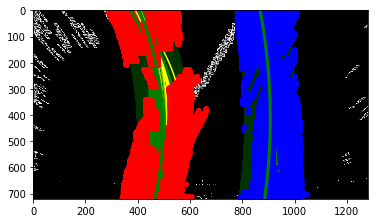

In [104]:
challenge_output = 'result_challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Test on Harder Challenge

1005.73916172 1565.41509234
143.708105131 m 264.198540812 m
0.335172434169
[MoviePy] >>>> Building video result_harder_challenge.mp4
[MoviePy] Writing video result_harder_challenge.mp4


  1%|          | 1/151 [00:01<02:34,  1.03s/it]

1005.73916172 1565.41509234
143.708105131 m 264.198540812 m
0.335172434169


  1%|▏         | 2/151 [00:02<02:31,  1.02s/it]

967.429197573 1388.77571368
127.680692963 m 223.294760487 m
0.361757668904


  2%|▏         | 3/151 [00:03<02:33,  1.04s/it]

516.043968277 1377.81979995
89.9188038302 m 217.717828935 m
0.227180111701


  3%|▎         | 4/151 [00:04<02:33,  1.05s/it]

489.571249649 1311.41326307
84.559773659 m 205.894467279 m
0.221762458586


  3%|▎         | 5/151 [00:05<02:33,  1.05s/it]

478.987005481 1301.92246023
82.1816678194 m 205.132091553 m
0.209156415653


  4%|▍         | 6/151 [00:06<02:31,  1.05s/it]

477.032092193 1558.09929297
82.2753157983 m 263.850053264 m
0.185686983735


  5%|▍         | 7/151 [00:07<02:30,  1.04s/it]

946.70390114 1705.87324532
129.230245394 m 297.02793558 m
0.293687025169


  5%|▌         | 8/151 [00:08<02:28,  1.04s/it]

977.124112201 1923.26497361
143.66312667 m 342.291368833 m
0.258186257142


  6%|▌         | 9/151 [00:09<02:27,  1.04s/it]

1264.30529486 4437.62205866
203.962080076 m 824.023870945 m
0.197362808664


  7%|▋         | 10/151 [00:10<02:26,  1.04s/it]

1380.8319592 18968.301667
230.664198461 m 3557.14577585 m
0.164891654249


  7%|▋         | 11/151 [00:11<02:30,  1.08s/it]

1299.07171514 15410.5834926
215.05673885 m 2889.92103135 m
0.155677230726


  8%|▊         | 12/151 [00:12<02:34,  1.11s/it]

1366.61275458 96262.2782695
231.089693431 m 18065.8497412 m
0.139833085101


  9%|▊         | 13/151 [00:13<02:35,  1.13s/it]

1351.40627444 9648.39398983
229.584116326 m 1806.99127737 m
0.139903860177


  9%|▉         | 14/151 [00:14<02:30,  1.10s/it]

1721.26545375 16040.7186884
303.121329083 m 3007.8989033 m
0.112247593631


 10%|▉         | 15/151 [00:16<02:28,  1.09s/it]

2393.06034267 12698.6482878
435.526917005 m 2382.82886049 m
0.0892314833385


 11%|█         | 16/151 [00:17<02:25,  1.08s/it]

3379.47185711 10837.1549758
624.87994302 m 2033.27376249 m
0.0792777431695


 11%|█▏        | 17/151 [00:18<02:21,  1.06s/it]

3170.85972681 7475.12403198
585.851444974 m 1402.08706293 m
0.0835047262528


 12%|█▏        | 18/151 [00:19<02:21,  1.06s/it]

3424.55070151 7122.32392522
635.232705081 m 1334.90084627 m
0.0678323679917


 13%|█▎        | 19/151 [00:20<02:25,  1.10s/it]

2420.50471976 4536.22325856
444.906062931 m 847.342413664 m
0.0738147807614


 13%|█▎        | 20/151 [00:21<02:30,  1.15s/it]

2193.75774018 83425.7634586
401.067092986 m 15644.8976446 m
0.0975021347013


 14%|█▍        | 21/151 [00:22<02:29,  1.15s/it]

1622.25985017 24187.36923
289.132436147 m 4532.48693553 m
0.113121369534


 15%|█▍        | 22/151 [00:23<02:23,  1.11s/it]

1816.87546961 34772.7605104
328.778549871 m 6526.10870336 m
0.0940880641334


 15%|█▌        | 23/151 [00:25<02:28,  1.16s/it]

2141.84861698 10955.7832407
391.211479157 m 2056.19144491 m
0.0926686926392


 16%|█▌        | 24/151 [00:26<02:25,  1.15s/it]

2051.94153231 17008.3788327
374.863191972 m 3191.83121268 m
0.0710524356775


 17%|█▋        | 25/151 [00:27<02:21,  1.12s/it]

6499.76636221 33745.55407
1217.88671487 m 6333.33088368 m
0.0630057474447


 17%|█▋        | 26/151 [00:28<02:17,  1.10s/it]

19933.1626101 14399.2058831
3740.95931233 m 2702.34913291 m
0.0499150050181


 18%|█▊        | 27/151 [00:29<02:13,  1.07s/it]

19813.3368659 90096.6434715
3711.6285426 m 16906.37133 m
0.0404895759385


 19%|█▊        | 28/151 [00:30<02:10,  1.06s/it]

18126.409667 71567.0678752
3392.51679071 m 13425.3264928 m
0.0374606251703


 19%|█▉        | 29/151 [00:31<02:09,  1.06s/it]

12134.2260398 36790.7227198
2277.20471505 m 6902.9694697 m
0.0356505650274


 20%|█▉        | 30/151 [00:32<02:08,  1.06s/it]

11579.1075775 11575.3686803
2172.53884453 m 2170.07695164 m
0.0343811978774


 21%|██        | 31/151 [00:33<02:07,  1.06s/it]

2967.08749365 4870.74890435
553.61041008 m 909.351227121 m
0.0693899463583


 21%|██        | 32/151 [00:34<02:06,  1.06s/it]

4559.42101896 5886.11750149
855.518284545 m 1101.72841987 m
0.0361749337996


 22%|██▏       | 33/151 [00:35<02:04,  1.05s/it]

2350.07870557 2645.30804239
437.437500648 m 484.341345605 m
0.0769668691882


 23%|██▎       | 34/151 [00:36<02:03,  1.05s/it]

1997.35742383 3362.92195269
369.195513462 m 623.128145399 m
0.0774581938026


 23%|██▎       | 35/151 [00:37<02:01,  1.05s/it]

1868.58709573 2831.76308
344.960519445 m 524.831669736 m
0.0816510958903


 24%|██▍       | 36/151 [00:38<02:00,  1.05s/it]

1682.87038304 2021.04902546
311.899738118 m 367.993491786 m
0.0941673030547


 25%|██▍       | 37/151 [00:39<01:57,  1.03s/it]

2199.85688387 2055.10039212
412.265576416 m 374.036464348 m
0.0838147269085


 25%|██▌       | 38/151 [00:40<01:56,  1.03s/it]

1644.19273954 3515.31005776
306.83477148 m 655.436597796 m
0.0721325441273


 26%|██▌       | 39/151 [00:41<01:55,  1.03s/it]

1684.8047906 78844.9391715
314.320306961 m 14791.7780486 m
0.0636440999982


 26%|██▋       | 40/151 [00:42<01:55,  1.04s/it]

3341.968177 23328.2115382
626.631578825 m 4378.34619648 m
0.0511874300034


 27%|██▋       | 41/151 [00:43<01:53,  1.04s/it]

3704.52664877 10405.5098695
693.920699767 m 1946.44258906 m
0.0693630410317


 28%|██▊       | 42/151 [00:44<01:54,  1.05s/it]

5066.44004353 8422.12200816
946.091270195 m 1571.81026765 m
0.0692267569464


 28%|██▊       | 43/151 [00:46<01:55,  1.07s/it]

2303.53455509 3431.62040865
432.304710726 m 627.950865831 m
0.10714710784


 29%|██▉       | 44/151 [00:47<01:58,  1.11s/it]

2737.87264917 5644.24501916
513.820712711 m 1047.16940021 m
0.0877214469744


 30%|██▉       | 45/151 [00:48<01:54,  1.08s/it]

7529.25506783 4501.94953173
1396.33046493 m 833.821334619 m
0.0701429281043


 30%|███       | 46/151 [00:49<01:52,  1.07s/it]

3588.9773398 8592.11480668
673.504607374 m 1612.03242618 m
0.0544740870652


 31%|███       | 47/151 [00:50<01:51,  1.07s/it]

1629.0008696 60887.8514118
298.392965698 m 11427.11361 m
0.0930272699495


 32%|███▏      | 48/151 [00:51<01:59,  1.16s/it]

1977.16156294 9444.2836158
361.047576529 m 1771.76601103 m
0.0981489029019


 32%|███▏      | 49/151 [00:52<01:56,  1.14s/it]

1140.20360308 23716.7040999
186.918698818 m 4434.38801071 m
0.16584335613


 33%|███▎      | 50/151 [00:54<01:54,  1.13s/it]

1029.7439268 43316.5334117
159.602190556 m 8124.55046198 m
0.177654566532


 34%|███▍      | 51/151 [00:55<01:51,  1.11s/it]

1175.37226501 5312.95457146
193.579273003 m 994.858560639 m
0.148011983288


 34%|███▍      | 52/151 [00:56<01:51,  1.12s/it]

1049.77207646 2854.37188889
166.409571733 m 530.52586304 m
0.162621019419


 35%|███▌      | 53/151 [00:57<01:48,  1.11s/it]

1038.07665718 2694.68770772
164.070778779 m 496.184228441 m
0.157030430904


 36%|███▌      | 54/151 [00:58<01:46,  1.10s/it]

1314.64414357 2164.01202294
228.140036851 m 395.761692063 m
0.126967500875


 36%|███▋      | 55/151 [00:59<01:44,  1.08s/it]

1120.88018465 2774.35670811
186.466786231 m 509.538915071 m
0.143803937692


 37%|███▋      | 56/151 [01:00<01:42,  1.08s/it]

1236.01997296 1874.39284088
215.917529165 m 334.188176917 m
0.10774556704


 38%|███▊      | 57/151 [01:01<01:41,  1.08s/it]

1422.1752351 1655.11045734
254.72082211 m 290.102910642 m
0.0992264699357


 38%|███▊      | 58/151 [01:02<01:40,  1.08s/it]

2647.4383637 1899.92550552
494.138703024 m 342.352047999 m
0.0982411443346


 39%|███▉      | 59/151 [01:03<01:38,  1.07s/it]

2734.97937857 1774.18311699
510.229776344 m 314.562667613 m
0.0951692678732


 40%|███▉      | 60/151 [01:04<01:37,  1.07s/it]

3008.92480839 1676.31298565
563.090503618 m 296.208591355 m
0.0946506144125


 40%|████      | 61/151 [01:05<01:37,  1.08s/it]

1487.25015887 2117.24777091
269.849832151 m 380.654272303 m
0.133903802769


 41%|████      | 62/151 [01:06<01:35,  1.07s/it]

10103.8945283 2589.60882489
1895.03286317 m 473.951372058 m
0.116194664498


 42%|████▏     | 63/151 [01:07<01:33,  1.06s/it]

17082.1912122 4924.78770505
3195.56709628 m 915.221233274 m
0.122282431089


 42%|████▏     | 64/151 [01:09<01:31,  1.06s/it]

2719.65910329 8405.05102634
492.491145093 m 1566.91563445 m
0.110912532214


 43%|████▎     | 65/151 [01:10<01:31,  1.06s/it]

1376.91320185 2538322.8805
232.668214526 m 475617.004298 m
0.109139567948


 44%|████▎     | 66/151 [01:11<01:30,  1.07s/it]

1288.12059572 34635.9455655
211.571415376 m 6493.04306192 m
0.10513240509


 44%|████▍     | 67/151 [01:12<01:30,  1.08s/it]

1251.43730904 2426.71229901
204.688052603 m 439.259616439 m
0.0624093132449


 45%|████▌     | 68/151 [01:13<01:31,  1.10s/it]

1180.04366616 1439.65871186
186.505554154 m 249.802463682 m
0.0475889432735


 46%|████▌     | 69/151 [01:14<01:29,  1.09s/it]

1379.8824786 1428.7808013
228.660105592 m 249.90735029 m
0.0662911556673


 46%|████▋     | 70/151 [01:15<01:28,  1.09s/it]

1811.9923089 1752.08251632
315.199195833 m 315.618862032 m
0.0842150304982


 47%|████▋     | 71/151 [01:16<01:26,  1.08s/it]

2330.25589707 2474.23620673
413.569512628 m 455.896078883 m
0.0921301455615


 48%|████▊     | 72/151 [01:17<01:24,  1.07s/it]

4509.93120004 10595.674443
823.74183376 m 1988.61921421 m
0.127628397565


 48%|████▊     | 73/151 [01:18<01:22,  1.06s/it]

5461.95077414 18873.81266
998.438394297 m 3535.59122756 m
0.137859886101


 49%|████▉     | 74/151 [01:19<01:23,  1.08s/it]

3938.51494836 5861.99658761
709.800769076 m 1092.34292994 m
0.141312389238


 50%|████▉     | 75/151 [01:21<01:24,  1.11s/it]

5112.51773415 24154.0923989
929.824760049 m 4529.6831905 m
0.139558051748


 50%|█████     | 76/151 [01:22<01:24,  1.13s/it]

6193.03972745 30950.0897378
1133.05495327 m 5808.74573702 m
0.128587661693


 51%|█████     | 77/151 [01:23<01:22,  1.12s/it]

13997.1260417 30365.9877083
2580.19792297 m 5690.59983132 m
0.105929763075


 52%|█████▏    | 78/151 [01:24<01:21,  1.11s/it]

5747.89721515 5345.21117707
1076.92566833 m 998.705850665 m
0.134620807263


 52%|█████▏    | 79/151 [01:25<01:18,  1.09s/it]

2675.71601075 2781.46435321
501.149936242 m 513.565751092 m
0.156837549677


 53%|█████▎    | 80/151 [01:26<01:16,  1.07s/it]

2656.65655953 5123.53812856
495.074015824 m 956.903448818 m
0.162358407469


 54%|█████▎    | 81/151 [01:27<01:17,  1.10s/it]

4681.83077104 3832.95708798
877.457133866 m 713.371167052 m
0.145124970174


 54%|█████▍    | 82/151 [01:28<01:14,  1.09s/it]

6410.51752333 71242.7412002
1202.80926789 m 13361.5794809 m
0.114694549879


 55%|█████▍    | 83/151 [01:29<01:13,  1.08s/it]

6771.85838861 10960.2527934
1270.5962739 m 2057.07639371 m
0.122588028997


 56%|█████▌    | 84/151 [01:30<01:11,  1.07s/it]

2573.59961104 1317.32914141
475.728496631 m 218.224490814 m
0.0535789413363


 56%|█████▋    | 85/151 [01:31<01:10,  1.07s/it]

2154.26212003 1759.54489387
394.387517471 m 314.90514588 m
0.0915057457647


 57%|█████▋    | 86/151 [01:32<01:09,  1.07s/it]

1428.05957535 4388.22558128
247.65591178 m 819.714067982 m
0.136905685351


 58%|█████▊    | 87/151 [01:33<01:08,  1.06s/it]

1223.56413199 5946.90717704
202.541888931 m 1112.3079543 m
0.142747226842


 58%|█████▊    | 88/151 [01:35<01:06,  1.06s/it]

1232.87296705 16153.2524176
202.15264327 m 3029.85743777 m
0.153917191314


 59%|█████▉    | 89/151 [01:36<01:05,  1.06s/it]

1652.36052714 9874.78149063
290.514529932 m 1852.13538409 m
0.170136178396


 60%|█████▉    | 90/151 [01:37<01:04,  1.06s/it]

1884.31992225 3612.94232389
338.125814958 m 673.072482704 m
0.170444771783


 60%|██████    | 91/151 [01:38<01:03,  1.05s/it]

3810.93021161 4670.19453343
706.477204239 m 874.949918191 m
0.165304260829


 61%|██████    | 92/151 [01:39<01:03,  1.08s/it]

4150.89846781 21184.2004213
772.089121042 m 3972.6149544 m
0.148073120091


 62%|██████▏   | 93/151 [01:40<01:02,  1.07s/it]

11791.2435687 26159.1086443
2211.23454297 m 4884.04748146 m
0.132430078373


 62%|██████▏   | 94/151 [01:41<01:00,  1.06s/it]

16500.8353985 13339.8687714
3093.56760172 m 2484.61792441 m
0.110555443044


 63%|██████▎   | 95/151 [01:42<00:59,  1.06s/it]

2873.92884988 35494.6748917
521.254921576 m 6644.76327182 m
0.0935214751487


 64%|██████▎   | 96/151 [01:43<00:58,  1.07s/it]

2412.78289251 86533.7073075
429.860291149 m 16229.2988437 m
0.0966615827125


 64%|██████▍   | 97/151 [01:44<00:57,  1.06s/it]

2696.77165331 10736.9952308
480.217219181 m 2011.06786271 m
0.0900355485779


 65%|██████▍   | 98/151 [01:45<00:57,  1.08s/it]

2962.49056338 3472.26304608
530.218458523 m 643.025629541 m
0.065880683754


 66%|██████▌   | 99/151 [01:46<00:57,  1.11s/it]

5279.35286765 5537.08072856
965.271345118 m 1033.35564164 m
0.0789984938453


 66%|██████▌   | 100/151 [01:48<00:57,  1.12s/it]

40612.0998997 10236.1194279
7559.85802991 m 1917.89180418 m
0.0958014404532


 67%|██████▋   | 101/151 [01:49<00:55,  1.11s/it]

24480.9401638 6153.12344025
4583.92238444 m 1149.91156747 m
0.11084479033


 68%|██████▊   | 102/151 [01:50<00:55,  1.13s/it]

3073.27458803 2598.71841127
573.495712567 m 479.540496227 m
0.13014477147


 68%|██████▊   | 103/151 [01:51<00:52,  1.09s/it]

2628.98491248 3276.38070761
488.797271025 m 609.306262909 m
0.137685460232


 69%|██████▉   | 104/151 [01:52<00:51,  1.09s/it]

1718.66393354 2938.35273556
311.181977881 m 547.530396984 m
0.160937719788


 70%|██████▉   | 105/151 [01:53<00:49,  1.07s/it]

1217.80734747 4906.36361602
207.944331388 m 919.961758732 m
0.183719773606


 70%|███████   | 106/151 [01:54<00:47,  1.06s/it]

1155.57050288 9417.2300482
193.988514932 m 1767.47945296 m
0.189880260329


 71%|███████   | 107/151 [01:55<00:45,  1.04s/it]

1508.12815783 420933.144661
266.324393044 m 78974.5082491 m
0.171924921032


 72%|███████▏  | 108/151 [01:56<00:45,  1.05s/it]

1703.85021357 6967.223848
306.258335441 m 1304.71140572 m
0.161790055805


 72%|███████▏  | 109/151 [01:57<00:45,  1.08s/it]

1435.8002183 3906.08198015
251.761942637 m 727.158180162 m
0.181939911718


 73%|███████▎  | 110/151 [01:58<00:44,  1.08s/it]

1322.36569086 4122.71266335
224.949088589 m 770.890588727 m
0.166221489076


 74%|███████▎  | 111/151 [01:59<00:42,  1.07s/it]

6702.7978977 4319.52778222
955.43730304 m 804.575622748 m
0.194348834658


 74%|███████▍  | 112/151 [02:00<00:42,  1.08s/it]

1490.65725273 3372.85852598
89.1626758594 m 622.9608954 m
0.310546602753


 75%|███████▍  | 113/151 [02:02<00:41,  1.09s/it]

1378.12977944 5321.82986438
78.0744330244 m 990.896999975 m
0.31120201363


 75%|███████▌  | 114/151 [02:03<00:43,  1.17s/it]

1250.84872534 16037.2367481
58.195448047 m 3007.70119071 m
0.321963219931


 76%|███████▌  | 115/151 [02:04<00:42,  1.19s/it]

1069.66384879 12155.6726486
64.3034395645 m 2278.63779893 m
0.283199853833


 77%|███████▋  | 116/151 [02:06<00:45,  1.30s/it]

959.856904116 17919.566007
76.6718270925 m 3358.69578284 m
0.222480869386


 77%|███████▋  | 117/151 [02:07<00:47,  1.41s/it]

863.356310425 7883.18883583
76.8994090767 m 1470.02177855 m
0.184088956694


 78%|███████▊  | 118/151 [02:09<00:48,  1.46s/it]

801.582773827 5242.92131822
88.3385393792 m 969.11349268 m
0.136591354227


 79%|███████▉  | 119/151 [02:10<00:46,  1.46s/it]

791.850423487 2888.02038914
97.1577953254 m 517.868524381 m
0.0824244347897


 79%|███████▉  | 120/151 [02:12<00:42,  1.37s/it]

969.86530908 1544.79867323
156.047259792 m 262.439079734 m
-0.0060461614295


 80%|████████  | 121/151 [02:13<00:39,  1.31s/it]

1295.19192318 2550.08056548
229.656013749 m 461.891102806 m
0.0116116123662


 81%|████████  | 122/151 [02:14<00:40,  1.39s/it]

2124.7409981 4877.40965536
392.37682289 m 900.956208938 m
0.0195529601753


 81%|████████▏ | 123/151 [02:16<00:40,  1.44s/it]

2834.66586959 16929.4756485
528.373326113 m 3174.7387788 m
0.0516250680838


 82%|████████▏ | 124/151 [02:17<00:37,  1.41s/it]

22715.2801991 4595.56612506
4255.01026806 m 852.990274904 m
0.0790537123071


 83%|████████▎ | 125/151 [02:19<00:36,  1.39s/it]

6276.56095014 2012.13279655
1161.41870634 m 360.112597164 m
0.115300287979


 83%|████████▎ | 126/151 [02:22<00:49,  1.96s/it]

2243.84799804 2457.06738882
396.515601139 m 451.585616699 m
0.0910256984428


 84%|████████▍ | 127/151 [02:23<00:42,  1.76s/it]

1803.5424281 4470.51944043
311.623115809 m 838.895570351 m
0.0752287557526


 85%|████████▍ | 128/151 [02:24<00:36,  1.59s/it]

1451.99075115 2015.74156053
240.375672309 m 347.382048897 m
0.0161430748511


 85%|████████▌ | 129/151 [02:26<00:35,  1.60s/it]

1237.59453788 1274.48697952
195.016309503 m 189.965142362 m
-0.0241842833721


 86%|████████▌ | 130/151 [02:27<00:32,  1.53s/it]

1187.90366046 1298.84377824
183.406254399 m 206.874484388 m
0.0217655980592


 87%|████████▋ | 131/151 [02:28<00:28,  1.41s/it]

1104.38305293 2275.19697754
168.614353502 m 413.271788765 m
0.107857093989


 87%|████████▋ | 132/151 [02:30<00:26,  1.38s/it]

1088.47144552 3290.30527497
165.997003585 m 609.926476117 m
0.138367922306


 88%|████████▊ | 133/151 [02:31<00:23,  1.30s/it]

1064.12746399 9348.36888823
167.79595922 m 1753.69174595 m
0.185208060428


 89%|████████▊ | 134/151 [02:32<00:22,  1.31s/it]

1179.64375818 14783.8121593
198.406634669 m 2774.65886746 m
0.228555503952


 89%|████████▉ | 135/151 [02:33<00:20,  1.27s/it]

1172.342227 24941.1182577
198.745508299 m 4680.64789401 m
0.250505060689


 90%|█████████ | 136/151 [02:35<00:19,  1.27s/it]

1355.48252417 25787.3951011
239.815713445 m 4839.6612822 m
0.273771406583


 91%|█████████ | 137/151 [02:36<00:17,  1.25s/it]

1356.15227915 50303.6840271
241.718453186 m 9438.10940951 m
0.289863837256


 91%|█████████▏| 138/151 [02:37<00:16,  1.24s/it]

1270.81152653 42647.7723995
223.900344077 m 7991.5144373 m
0.30094177505


 92%|█████████▏| 139/151 [02:38<00:14,  1.21s/it]

1233.12545453 362592.249027
217.044221944 m 67999.2195313 m
0.309199968834


 93%|█████████▎| 140/151 [02:39<00:12,  1.17s/it]

1334.53285286 48405.6904632
239.416243301 m 9071.00332156 m
0.325491475932


 93%|█████████▎| 141/151 [02:40<00:11,  1.17s/it]

1197.1447707 24586.5902343
209.838725458 m 4604.14015982 m
0.322888435651


 94%|█████████▍| 142/151 [02:42<00:10,  1.14s/it]

828.179857358 28741.760504
81.1101578298 m 5384.01807947 m
0.221478547998


 95%|█████████▍| 143/151 [02:43<00:09,  1.13s/it]

953.073653469 9704.85152593
64.8767443999 m 1810.64179791 m
0.180243056935


 95%|█████████▌| 144/151 [02:44<00:07,  1.10s/it]

1154.8681559 8267.53621737
57.9880915521 m 1540.11590665 m
0.133688947191


 96%|█████████▌| 145/151 [02:45<00:06,  1.07s/it]

817.988098129 9722.51621671
79.5686339614 m 1813.31778644 m
0.249582076622


 97%|█████████▋| 146/151 [02:46<00:05,  1.09s/it]

866.091311274 5124.80469255
70.6311609661 m 947.494418529 m
0.236994144792


 97%|█████████▋| 147/151 [02:47<00:04,  1.11s/it]

991.504838574 4297.18606509
60.0977367565 m 791.963714856 m
0.196089626538


 98%|█████████▊| 148/151 [02:48<00:03,  1.10s/it]

1094.27003587 3603.51357362
56.095416456 m 660.114676891 m
0.174154346113


 99%|█████████▊| 149/151 [02:49<00:02,  1.11s/it]

1064.62935051 2712.51821753
56.83895211 m 489.586711417 m
0.191255645578


 99%|█████████▉| 150/151 [02:50<00:01,  1.10s/it]

913.879538155 2419.75238666
63.2222315694 m 432.773222183 m
0.243957076503


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_harder_challenge.mp4 

CPU times: user 2min 40s, sys: 24.5 s, total: 3min 4s
Wall time: 2min 52s


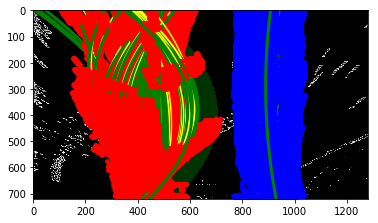

In [105]:
harder_challenge_output = 'result_harder_challenge.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,6)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))